In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(701992, 828)
(701992, 1)
validation
(107232, 828)
(107232, 1)
test
(76096, 828)
(76096, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/71 [..............................] - ETA: 1:31 - loss: 0.1654 - STD: 9.8110e-05 - MAE: 0.3935

 4/71 [>.............................] - ETA: 1s - loss: 0.0565 - STD: 3.9022e-04 - MAE: 0.1830  

 5/71 [=>............................] - ETA: 2s - loss: 0.0496 - STD: 3.4908e-04 - MAE: 0.1690

 6/71 [=>............................] - ETA: 2s - loss: 0.0456 - STD: 3.0968e-04 - MAE: 0.1620

 7/71 [=>............................] - ETA: 3s - loss: 0.0432 - STD: 2.7617e-04 - MAE: 0.1582

 8/71 [==>...........................] - ETA: 3s - loss: 0.0415 - STD: 2.4812e-04 - MAE: 0.1561

 9/71 [==>...........................] - ETA: 3s - loss: 0.0403 - STD: 2.2457e-04 - MAE: 0.1547

10/71 [===>..........................] - ETA: 3s - loss: 0.0394 - STD: 2.0473e-04 - MAE: 0.1536

11/71 [===>..........................] - ETA: 3s - loss: 0.0386 - STD: 1.8787e-04 - MAE: 0.1525

12/71 [====>.........................] - ETA: 3s - loss: 0.0378 - STD: 1.7338e-04 - MAE: 0.1513

13/71 [====>.........................] - ETA: 3s - loss: 0.0371 - STD: 1.6095e-04 - MAE: 0.1501

14/71 [====>.........................] - ETA: 3s - loss: 0.0364 - STD: 1.5030e-04 - MAE: 0.1488

15/71 [=====>........................] - ETA: 3s - loss: 0.0356 - STD: 1.4124e-04 - MAE: 0.1471

16/71 [=====>........................] - ETA: 3s - loss: 0.0348 - STD: 1.3353e-04 - MAE: 0.1453

17/71 [======>.......................] - ETA: 3s - loss: 0.0341 - STD: 1.2698e-04 - MAE: 0.1433

18/71 [======>.......................] - ETA: 3s - loss: 0.0332 - STD: 1.2138e-04 - MAE: 0.1409

19/71 [=======>......................] - ETA: 3s - loss: 0.0324 - STD: 1.1656e-04 - MAE: 0.1385

20/71 [=======>......................] - ETA: 3s - loss: 0.0314 - STD: 1.1242e-04 - MAE: 0.1358

21/71 [=======>......................] - ETA: 3s - loss: 0.0305 - STD: 1.0877e-04 - MAE: 0.1332

22/71 [========>.....................] - ETA: 3s - loss: 0.0297 - STD: 1.0568e-04 - MAE: 0.1307

23/71 [========>.....................] - ETA: 2s - loss: 0.0288 - STD: 1.0304e-04 - MAE: 0.1285

24/71 [=========>....................] - ETA: 2s - loss: 0.0281 - STD: 1.0065e-04 - MAE: 0.1266

25/71 [=========>....................] - ETA: 2s - loss: 0.0274 - STD: 9.8465e-05 - MAE: 0.1251

26/71 [=========>....................] - ETA: 2s - loss: 0.0269 - STD: 9.6392e-05 - MAE: 0.1239

27/71 [==========>...................] - ETA: 2s - loss: 0.0264 - STD: 9.4365e-05 - MAE: 0.1229

28/71 [==========>...................] - ETA: 2s - loss: 0.0259 - STD: 9.2452e-05 - MAE: 0.1221

29/71 [===========>..................] - ETA: 2s - loss: 0.0255 - STD: 9.0542e-05 - MAE: 0.1214

30/71 [===========>..................] - ETA: 2s - loss: 0.0251 - STD: 8.8617e-05 - MAE: 0.1206

31/71 [============>.................] - ETA: 2s - loss: 0.0247 - STD: 8.6675e-05 - MAE: 0.1198

32/71 [============>.................] - ETA: 2s - loss: 0.0243 - STD: 8.4804e-05 - MAE: 0.1189

33/71 [============>.................] - ETA: 2s - loss: 0.0239 - STD: 8.2926e-05 - MAE: 0.1179

34/71 [=============>................] - ETA: 2s - loss: 0.0235 - STD: 8.1072e-05 - MAE: 0.1169

35/71 [=============>................] - ETA: 2s - loss: 0.0231 - STD: 7.9284e-05 - MAE: 0.1159

36/71 [==============>...............] - ETA: 2s - loss: 0.0228 - STD: 7.7528e-05 - MAE: 0.1149

37/71 [==============>...............] - ETA: 2s - loss: 0.0224 - STD: 7.5816e-05 - MAE: 0.1139

38/71 [===============>..............] - ETA: 2s - loss: 0.0221 - STD: 7.4168e-05 - MAE: 0.1129

39/71 [===============>..............] - ETA: 2s - loss: 0.0219 - STD: 7.2615e-05 - MAE: 0.1121

40/71 [===============>..............] - ETA: 1s - loss: 0.0216 - STD: 7.1157e-05 - MAE: 0.1112

41/71 [================>.............] - ETA: 1s - loss: 0.0214 - STD: 6.9760e-05 - MAE: 0.1104

42/71 [================>.............] - ETA: 1s - loss: 0.0211 - STD: 6.8421e-05 - MAE: 0.1097

43/71 [=================>............] - ETA: 1s - loss: 0.0209 - STD: 6.7166e-05 - MAE: 0.1090

44/71 [=================>............] - ETA: 1s - loss: 0.0207 - STD: 6.5948e-05 - MAE: 0.1083

45/71 [==================>...........] - ETA: 1s - loss: 0.0205 - STD: 6.4780e-05 - MAE: 0.1076

46/71 [==================>...........] - ETA: 1s - loss: 0.0203 - STD: 6.3687e-05 - MAE: 0.1070

47/71 [==================>...........] - ETA: 1s - loss: 0.0201 - STD: 6.2647e-05 - MAE: 0.1064

48/71 [===================>..........] - ETA: 1s - loss: 0.0200 - STD: 6.1650e-05 - MAE: 0.1058

52/71 [====================>.........] - ETA: 1s - loss: 0.0193 - STD: 5.8073e-05 - MAE: 0.1040

53/71 [=====================>........] - ETA: 1s - loss: 0.0191 - STD: 5.7286e-05 - MAE: 0.1036

54/71 [=====================>........] - ETA: 1s - loss: 0.0190 - STD: 5.6514e-05 - MAE: 0.1032

55/71 [======================>.......] - ETA: 1s - loss: 0.0188 - STD: 5.5769e-05 - MAE: 0.1029

56/71 [======================>.......] - ETA: 1s - loss: 0.0187 - STD: 5.5049e-05 - MAE: 0.1025

57/71 [=======================>......] - ETA: 0s - loss: 0.0185 - STD: 5.4385e-05 - MAE: 0.1022

58/71 [=======================>......] - ETA: 0s - loss: 0.0184 - STD: 5.3724e-05 - MAE: 0.1019

59/71 [=======================>......] - ETA: 0s - loss: 0.0183 - STD: 5.3090e-05 - MAE: 0.1015

60/71 [========================>.....] - ETA: 0s - loss: 0.0181 - STD: 5.2498e-05 - MAE: 0.1012

61/71 [========================>.....] - ETA: 0s - loss: 0.0180 - STD: 5.1951e-05 - MAE: 0.1009

62/71 [=========================>....] - ETA: 0s - loss: 0.0179 - STD: 5.1375e-05 - MAE: 0.1005

63/71 [=========================>....] - ETA: 0s - loss: 0.0178 - STD: 5.0840e-05 - MAE: 0.1002

64/71 [==========================>...] - ETA: 0s - loss: 0.0177 - STD: 5.0322e-05 - MAE: 0.0999

65/71 [==========================>...] - ETA: 0s - loss: 0.0176 - STD: 4.9824e-05 - MAE: 0.0995

66/71 [==========================>...] - ETA: 0s - loss: 0.0174 - STD: 4.9352e-05 - MAE: 0.0992

67/71 [===========================>..] - ETA: 0s - loss: 0.0173 - STD: 4.8895e-05 - MAE: 0.0989

68/71 [===========================>..] - ETA: 0s - loss: 0.0172 - STD: 4.8458e-05 - MAE: 0.0986

69/71 [============================>.] - ETA: 0s - loss: 0.0172 - STD: 4.8035e-05 - MAE: 0.0984

70/71 [============================>.] - ETA: 0s - loss: 0.0171 - STD: 4.7626e-05 - MAE: 0.0981

71/71 [==============================] - ETA: 0s - loss: 0.0170 - STD: 4.7229e-05 - MAE: 0.0978

71/71 [==============================] - 7s 79ms/step - loss: 0.0170 - STD: 4.7229e-05 - MAE: 0.0978 - val_loss: 0.0116 - val_STD: 1.9080e-05 - val_MAE: 0.0818


Epoch 2/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0107 - STD: 2.0989e-05 - MAE: 0.0797

 2/71 [..............................] - ETA: 4s - loss: 0.0107 - STD: 2.1108e-05 - MAE: 0.0799

 3/71 [>.............................] - ETA: 4s - loss: 0.0106 - STD: 2.1070e-05 - MAE: 0.0800

 4/71 [>.............................] - ETA: 4s - loss: 0.0106 - STD: 2.1222e-05 - MAE: 0.0800

 5/71 [=>............................] - ETA: 4s - loss: 0.0106 - STD: 2.1518e-05 - MAE: 0.0801

 6/71 [=>............................] - ETA: 4s - loss: 0.0106 - STD: 2.1714e-05 - MAE: 0.0801

 7/71 [=>............................] - ETA: 4s - loss: 0.0105 - STD: 2.1883e-05 - MAE: 0.0801

 8/71 [==>...........................] - ETA: 4s - loss: 0.0106 - STD: 2.2073e-05 - MAE: 0.0803

 9/71 [==>...........................] - ETA: 4s - loss: 0.0106 - STD: 2.2272e-05 - MAE: 0.0804

10/71 [===>..........................] - ETA: 4s - loss: 0.0106 - STD: 2.2460e-05 - MAE: 0.0806

11/71 [===>..........................] - ETA: 4s - loss: 0.0106 - STD: 2.2686e-05 - MAE: 0.0806

12/71 [====>.........................] - ETA: 4s - loss: 0.0106 - STD: 2.2951e-05 - MAE: 0.0806

13/71 [====>.........................] - ETA: 4s - loss: 0.0105 - STD: 2.3099e-05 - MAE: 0.0805

14/71 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 2.3300e-05 - MAE: 0.0805

15/71 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 2.3507e-05 - MAE: 0.0806

16/71 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 2.3714e-05 - MAE: 0.0806

17/71 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 2.3999e-05 - MAE: 0.0805

18/71 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 2.4283e-05 - MAE: 0.0806

19/71 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 2.4563e-05 - MAE: 0.0805

20/71 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 2.4816e-05 - MAE: 0.0805

21/71 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 2.5071e-05 - MAE: 0.0804

22/71 [========>.....................] - ETA: 3s - loss: 0.0106 - STD: 2.5337e-05 - MAE: 0.0804

23/71 [========>.....................] - ETA: 3s - loss: 0.0106 - STD: 2.5594e-05 - MAE: 0.0803

24/71 [=========>....................] - ETA: 3s - loss: 0.0106 - STD: 2.5836e-05 - MAE: 0.0803

25/71 [=========>....................] - ETA: 3s - loss: 0.0106 - STD: 2.6057e-05 - MAE: 0.0803

26/71 [=========>....................] - ETA: 3s - loss: 0.0106 - STD: 2.6300e-05 - MAE: 0.0803

27/71 [==========>...................] - ETA: 3s - loss: 0.0106 - STD: 2.6499e-05 - MAE: 0.0803

28/71 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 2.6687e-05 - MAE: 0.0803

29/71 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 2.6895e-05 - MAE: 0.0804

30/71 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 2.7115e-05 - MAE: 0.0804

31/71 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 2.7357e-05 - MAE: 0.0804

32/71 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 2.7605e-05 - MAE: 0.0804

33/71 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 2.7858e-05 - MAE: 0.0804

34/71 [=============>................] - ETA: 2s - loss: 0.0106 - STD: 2.8104e-05 - MAE: 0.0804

35/71 [=============>................] - ETA: 2s - loss: 0.0106 - STD: 2.8361e-05 - MAE: 0.0804

36/71 [==============>...............] - ETA: 2s - loss: 0.0106 - STD: 2.8611e-05 - MAE: 0.0804

37/71 [==============>...............] - ETA: 2s - loss: 0.0106 - STD: 2.8872e-05 - MAE: 0.0804

38/71 [===============>..............] - ETA: 2s - loss: 0.0106 - STD: 2.9147e-05 - MAE: 0.0804

39/71 [===============>..............] - ETA: 2s - loss: 0.0106 - STD: 2.9412e-05 - MAE: 0.0804

40/71 [===============>..............] - ETA: 2s - loss: 0.0106 - STD: 2.9681e-05 - MAE: 0.0804

41/71 [================>.............] - ETA: 2s - loss: 0.0106 - STD: 2.9977e-05 - MAE: 0.0803

43/71 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 3.0611e-05 - MAE: 0.0804

44/71 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 3.0932e-05 - MAE: 0.0804

45/71 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 3.1246e-05 - MAE: 0.0804

46/71 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 3.1581e-05 - MAE: 0.0804

47/71 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 3.1911e-05 - MAE: 0.0803

48/71 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 3.2268e-05 - MAE: 0.0804

49/71 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 3.2620e-05 - MAE: 0.0803

50/71 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 3.2991e-05 - MAE: 0.0803

51/71 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 3.3365e-05 - MAE: 0.0803

52/71 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 3.3753e-05 - MAE: 0.0803

53/71 [=====================>........] - ETA: 1s - loss: 0.0106 - STD: 3.4154e-05 - MAE: 0.0804

54/71 [=====================>........] - ETA: 1s - loss: 0.0106 - STD: 3.4551e-05 - MAE: 0.0804

55/71 [======================>.......] - ETA: 1s - loss: 0.0106 - STD: 3.4954e-05 - MAE: 0.0804

56/71 [======================>.......] - ETA: 0s - loss: 0.0106 - STD: 3.5381e-05 - MAE: 0.0804

57/71 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 3.5809e-05 - MAE: 0.0804

58/71 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 3.6248e-05 - MAE: 0.0804

59/71 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 3.6695e-05 - MAE: 0.0804

60/71 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 3.7153e-05 - MAE: 0.0804

61/71 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 3.7611e-05 - MAE: 0.0804

62/71 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 3.8087e-05 - MAE: 0.0804

63/71 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 3.8572e-05 - MAE: 0.0804

64/71 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 3.9048e-05 - MAE: 0.0804

65/71 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 3.9538e-05 - MAE: 0.0804

66/71 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 4.0038e-05 - MAE: 0.0804

67/71 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 4.0549e-05 - MAE: 0.0804

68/71 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 4.1058e-05 - MAE: 0.0804

69/71 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 4.1562e-05 - MAE: 0.0804

70/71 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 4.2084e-05 - MAE: 0.0804

71/71 [==============================] - ETA: 0s - loss: 0.0106 - STD: 4.2608e-05 - MAE: 0.0804

71/71 [==============================] - 5s 70ms/step - loss: 0.0106 - STD: 4.2608e-05 - MAE: 0.0804 - val_loss: 0.0115 - val_STD: 7.3516e-05 - val_MAE: 0.0820


Epoch 3/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0108 - STD: 8.0852e-05 - MAE: 0.0811

 2/71 [..............................] - ETA: 5s - loss: 0.0107 - STD: 8.1459e-05 - MAE: 0.0806

 3/71 [>.............................] - ETA: 4s - loss: 0.0107 - STD: 8.2334e-05 - MAE: 0.0804

 4/71 [>.............................] - ETA: 4s - loss: 0.0106 - STD: 8.3191e-05 - MAE: 0.0804

 5/71 [=>............................] - ETA: 4s - loss: 0.0106 - STD: 8.3850e-05 - MAE: 0.0801

 6/71 [=>............................] - ETA: 4s - loss: 0.0106 - STD: 8.4660e-05 - MAE: 0.0800

 7/71 [=>............................] - ETA: 4s - loss: 0.0106 - STD: 8.5466e-05 - MAE: 0.0800

 8/71 [==>...........................] - ETA: 4s - loss: 0.0106 - STD: 8.6338e-05 - MAE: 0.0800

10/71 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 8.8258e-05 - MAE: 0.0802

11/71 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 8.9323e-05 - MAE: 0.0802

12/71 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 9.0371e-05 - MAE: 0.0802

13/71 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 9.1405e-05 - MAE: 0.0803

14/71 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 9.2465e-05 - MAE: 0.0803

15/71 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 9.3625e-05 - MAE: 0.0803

16/71 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 9.4800e-05 - MAE: 0.0803

17/71 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 9.5901e-05 - MAE: 0.0803

18/71 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 9.7158e-05 - MAE: 0.0803

19/71 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 9.8316e-05 - MAE: 0.0803

20/71 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 9.9593e-05 - MAE: 0.0803

21/71 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 1.0086e-04 - MAE: 0.0803

22/71 [========>.....................] - ETA: 3s - loss: 0.0106 - STD: 1.0215e-04 - MAE: 0.0803

23/71 [========>.....................] - ETA: 3s - loss: 0.0106 - STD: 1.0353e-04 - MAE: 0.0803

24/71 [=========>....................] - ETA: 3s - loss: 0.0106 - STD: 1.0497e-04 - MAE: 0.0803

25/71 [=========>....................] - ETA: 3s - loss: 0.0106 - STD: 1.0640e-04 - MAE: 0.0803

26/71 [=========>....................] - ETA: 2s - loss: 0.0106 - STD: 1.0789e-04 - MAE: 0.0803

27/71 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 1.0940e-04 - MAE: 0.0803

28/71 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 1.1093e-04 - MAE: 0.0803

29/71 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 1.1251e-04 - MAE: 0.0803

30/71 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 1.1415e-04 - MAE: 0.0803

31/71 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 1.1574e-04 - MAE: 0.0803

32/71 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 1.1739e-04 - MAE: 0.0803

33/71 [============>.................] - ETA: 2s - loss: 0.0106 - STD: 1.1916e-04 - MAE: 0.0803

34/71 [=============>................] - ETA: 2s - loss: 0.0106 - STD: 1.2094e-04 - MAE: 0.0803

35/71 [=============>................] - ETA: 2s - loss: 0.0106 - STD: 1.2275e-04 - MAE: 0.0803

36/71 [==============>...............] - ETA: 2s - loss: 0.0106 - STD: 1.2462e-04 - MAE: 0.0803

37/71 [==============>...............] - ETA: 2s - loss: 0.0106 - STD: 1.2655e-04 - MAE: 0.0803

38/71 [===============>..............] - ETA: 2s - loss: 0.0106 - STD: 1.2851e-04 - MAE: 0.0803

39/71 [===============>..............] - ETA: 2s - loss: 0.0106 - STD: 1.3058e-04 - MAE: 0.0803

40/71 [===============>..............] - ETA: 2s - loss: 0.0106 - STD: 1.3267e-04 - MAE: 0.0803

41/71 [================>.............] - ETA: 2s - loss: 0.0106 - STD: 1.3480e-04 - MAE: 0.0803

42/71 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 1.3699e-04 - MAE: 0.0803

43/71 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 1.3933e-04 - MAE: 0.0803

44/71 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 1.4173e-04 - MAE: 0.0803

45/71 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 1.4413e-04 - MAE: 0.0803

46/71 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 1.4664e-04 - MAE: 0.0803

47/71 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 1.4927e-04 - MAE: 0.0803

48/71 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 1.5198e-04 - MAE: 0.0803

49/71 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 1.5474e-04 - MAE: 0.0803

50/71 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 1.5761e-04 - MAE: 0.0803

51/71 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 1.6058e-04 - MAE: 0.0803

52/71 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 1.6367e-04 - MAE: 0.0803

53/71 [=====================>........] - ETA: 1s - loss: 0.0106 - STD: 1.6680e-04 - MAE: 0.0803

54/71 [=====================>........] - ETA: 1s - loss: 0.0106 - STD: 1.6998e-04 - MAE: 0.0803

55/71 [======================>.......] - ETA: 1s - loss: 0.0106 - STD: 1.7334e-04 - MAE: 0.0803

56/71 [======================>.......] - ETA: 1s - loss: 0.0106 - STD: 1.7681e-04 - MAE: 0.0803

57/71 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 1.8040e-04 - MAE: 0.0803

58/71 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 1.8414e-04 - MAE: 0.0802

59/71 [=======================>......] - ETA: 0s - loss: 0.0106 - STD: 1.8801e-04 - MAE: 0.0803

60/71 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 1.9198e-04 - MAE: 0.0802

61/71 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 1.9615e-04 - MAE: 0.0802

62/71 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 2.0046e-04 - MAE: 0.0802

63/71 [=========================>....] - ETA: 0s - loss: 0.0106 - STD: 2.0495e-04 - MAE: 0.0802

64/71 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 2.0955e-04 - MAE: 0.0802

65/71 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 2.1443e-04 - MAE: 0.0802

66/71 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 2.1944e-04 - MAE: 0.0802

67/71 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 2.2459e-04 - MAE: 0.0802

68/71 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 2.3004e-04 - MAE: 0.0802

69/71 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 2.3558e-04 - MAE: 0.0802

70/71 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 2.4136e-04 - MAE: 0.0802

71/71 [==============================] - ETA: 0s - loss: 0.0106 - STD: 2.4742e-04 - MAE: 0.0802

71/71 [==============================] - 5s 71ms/step - loss: 0.0106 - STD: 2.4742e-04 - MAE: 0.0802 - val_loss: 0.0115 - val_STD: 6.3244e-04 - val_MAE: 0.0817


Epoch 4/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0102 - STD: 6.9380e-04 - MAE: 0.0782

 2/71 [..............................] - ETA: 4s - loss: 0.0105 - STD: 7.1168e-04 - MAE: 0.0794

 3/71 [>.............................] - ETA: 4s - loss: 0.0106 - STD: 7.3187e-04 - MAE: 0.0799

 4/71 [>.............................] - ETA: 4s - loss: 0.0107 - STD: 7.4944e-04 - MAE: 0.0804

 5/71 [=>............................] - ETA: 4s - loss: 0.0107 - STD: 7.6967e-04 - MAE: 0.0804

 6/71 [=>............................] - ETA: 4s - loss: 0.0107 - STD: 7.8784e-04 - MAE: 0.0804

 7/71 [=>............................] - ETA: 4s - loss: 0.0106 - STD: 8.0825e-04 - MAE: 0.0804

 8/71 [==>...........................] - ETA: 4s - loss: 0.0106 - STD: 8.2874e-04 - MAE: 0.0804

 9/71 [==>...........................] - ETA: 4s - loss: 0.0106 - STD: 8.4890e-04 - MAE: 0.0804

10/71 [===>..........................] - ETA: 4s - loss: 0.0106 - STD: 8.7177e-04 - MAE: 0.0804

11/71 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 8.9459e-04 - MAE: 0.0804

12/71 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 9.1758e-04 - MAE: 0.0803

13/71 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 9.4197e-04 - MAE: 0.0803

14/71 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 9.6669e-04 - MAE: 0.0802

15/71 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 9.9242e-04 - MAE: 0.0802

16/71 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 0.0010 - MAE: 0.0803    

17/71 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 0.0010 - MAE: 0.0803

18/71 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 0.0011 - MAE: 0.0803

19/71 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 0.0011 - MAE: 0.0804

20/71 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 0.0011 - MAE: 0.0803

21/71 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 0.0012 - MAE: 0.0802

22/71 [========>.....................] - ETA: 3s - loss: 0.0105 - STD: 0.0012 - MAE: 0.0802

23/71 [========>.....................] - ETA: 3s - loss: 0.0105 - STD: 0.0012 - MAE: 0.0802

24/71 [=========>....................] - ETA: 3s - loss: 0.0105 - STD: 0.0013 - MAE: 0.0801

25/71 [=========>....................] - ETA: 3s - loss: 0.0105 - STD: 0.0013 - MAE: 0.0801

26/71 [=========>....................] - ETA: 2s - loss: 0.0105 - STD: 0.0014 - MAE: 0.0801

27/71 [==========>...................] - ETA: 2s - loss: 0.0105 - STD: 0.0014 - MAE: 0.0800

28/71 [==========>...................] - ETA: 2s - loss: 0.0105 - STD: 0.0015 - MAE: 0.0800

29/71 [===========>..................] - ETA: 2s - loss: 0.0105 - STD: 0.0015 - MAE: 0.0800

30/71 [===========>..................] - ETA: 2s - loss: 0.0105 - STD: 0.0016 - MAE: 0.0800

31/71 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 0.0016 - MAE: 0.0799

32/71 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 0.0017 - MAE: 0.0799

33/71 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 0.0017 - MAE: 0.0799

34/71 [=============>................] - ETA: 2s - loss: 0.0105 - STD: 0.0018 - MAE: 0.0798

35/71 [=============>................] - ETA: 2s - loss: 0.0104 - STD: 0.0018 - MAE: 0.0798

36/71 [==============>...............] - ETA: 2s - loss: 0.0104 - STD: 0.0019 - MAE: 0.0798

37/71 [==============>...............] - ETA: 2s - loss: 0.0104 - STD: 0.0020 - MAE: 0.0798

38/71 [===============>..............] - ETA: 2s - loss: 0.0104 - STD: 0.0021 - MAE: 0.0797

39/71 [===============>..............] - ETA: 2s - loss: 0.0104 - STD: 0.0021 - MAE: 0.0797

40/71 [===============>..............] - ETA: 2s - loss: 0.0104 - STD: 0.0022 - MAE: 0.0797

41/71 [================>.............] - ETA: 2s - loss: 0.0104 - STD: 0.0023 - MAE: 0.0796

42/71 [================>.............] - ETA: 1s - loss: 0.0104 - STD: 0.0024 - MAE: 0.0796

43/71 [=================>............] - ETA: 1s - loss: 0.0104 - STD: 0.0025 - MAE: 0.0795

44/71 [=================>............] - ETA: 1s - loss: 0.0104 - STD: 0.0026 - MAE: 0.0795

45/71 [==================>...........] - ETA: 1s - loss: 0.0104 - STD: 0.0027 - MAE: 0.0795

46/71 [==================>...........] - ETA: 1s - loss: 0.0104 - STD: 0.0028 - MAE: 0.0794

47/71 [==================>...........] - ETA: 1s - loss: 0.0103 - STD: 0.0029 - MAE: 0.0794

48/71 [===================>..........] - ETA: 1s - loss: 0.0103 - STD: 0.0030 - MAE: 0.0793

49/71 [===================>..........] - ETA: 1s - loss: 0.0103 - STD: 0.0031 - MAE: 0.0793

50/71 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.0032 - MAE: 0.0793

51/71 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.0034 - MAE: 0.0793

52/71 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.0035 - MAE: 0.0792

53/71 [=====================>........] - ETA: 1s - loss: 0.0103 - STD: 0.0037 - MAE: 0.0792

54/71 [=====================>........] - ETA: 1s - loss: 0.0103 - STD: 0.0038 - MAE: 0.0791

55/71 [======================>.......] - ETA: 1s - loss: 0.0102 - STD: 0.0040 - MAE: 0.0791

56/71 [======================>.......] - ETA: 1s - loss: 0.0102 - STD: 0.0041 - MAE: 0.0790

57/71 [=======================>......] - ETA: 0s - loss: 0.0102 - STD: 0.0043 - MAE: 0.0790

58/71 [=======================>......] - ETA: 0s - loss: 0.0102 - STD: 0.0045 - MAE: 0.0789

59/71 [=======================>......] - ETA: 0s - loss: 0.0102 - STD: 0.0046 - MAE: 0.0789

60/71 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 0.0048 - MAE: 0.0788

61/71 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 0.0050 - MAE: 0.0788

62/71 [=========================>....] - ETA: 0s - loss: 0.0101 - STD: 0.0052 - MAE: 0.0787

63/71 [=========================>....] - ETA: 0s - loss: 0.0101 - STD: 0.0054 - MAE: 0.0787

64/71 [==========================>...] - ETA: 0s - loss: 0.0101 - STD: 0.0057 - MAE: 0.0786

65/71 [==========================>...] - ETA: 0s - loss: 0.0101 - STD: 0.0059 - MAE: 0.0786

66/71 [==========================>...] - ETA: 0s - loss: 0.0101 - STD: 0.0061 - MAE: 0.0785

67/71 [===========================>..] - ETA: 0s - loss: 0.0101 - STD: 0.0064 - MAE: 0.0784

68/71 [===========================>..] - ETA: 0s - loss: 0.0101 - STD: 0.0066 - MAE: 0.0784

69/71 [============================>.] - ETA: 0s - loss: 0.0100 - STD: 0.0069 - MAE: 0.0783

70/71 [============================>.] - ETA: 0s - loss: 0.0100 - STD: 0.0071 - MAE: 0.0782

71/71 [==============================] - 5s 68ms/step - loss: 0.0100 - STD: 0.0074 - MAE: 0.0782 - val_loss: 0.0097 - val_STD: 0.0252 - val_MAE: 0.0760


Epoch 5/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0087 - STD: 0.0274 - MAE: 0.0730

 2/71 [..............................] - ETA: 4s - loss: 0.0087 - STD: 0.0279 - MAE: 0.0732

 3/71 [>.............................] - ETA: 4s - loss: 0.0087 - STD: 0.0285 - MAE: 0.0730

 4/71 [>.............................] - ETA: 4s - loss: 0.0087 - STD: 0.0290 - MAE: 0.0729

 5/71 [=>............................] - ETA: 3s - loss: 0.0087 - STD: 0.0294 - MAE: 0.0729

 6/71 [=>............................] - ETA: 3s - loss: 0.0086 - STD: 0.0299 - MAE: 0.0729

 7/71 [=>............................] - ETA: 3s - loss: 0.0086 - STD: 0.0304 - MAE: 0.0727

 8/71 [==>...........................] - ETA: 3s - loss: 0.0086 - STD: 0.0309 - MAE: 0.0727

 9/71 [==>...........................] - ETA: 3s - loss: 0.0086 - STD: 0.0314 - MAE: 0.0725

10/71 [===>..........................] - ETA: 3s - loss: 0.0086 - STD: 0.0318 - MAE: 0.0724

11/71 [===>..........................] - ETA: 3s - loss: 0.0085 - STD: 0.0323 - MAE: 0.0723

12/71 [====>.........................] - ETA: 3s - loss: 0.0085 - STD: 0.0327 - MAE: 0.0721

13/71 [====>.........................] - ETA: 3s - loss: 0.0085 - STD: 0.0331 - MAE: 0.0719

14/71 [====>.........................] - ETA: 3s - loss: 0.0084 - STD: 0.0335 - MAE: 0.0719

15/71 [=====>........................] - ETA: 3s - loss: 0.0084 - STD: 0.0339 - MAE: 0.0718

16/71 [=====>........................] - ETA: 3s - loss: 0.0084 - STD: 0.0343 - MAE: 0.0717

17/71 [======>.......................] - ETA: 3s - loss: 0.0084 - STD: 0.0346 - MAE: 0.0716

18/71 [======>.......................] - ETA: 3s - loss: 0.0084 - STD: 0.0350 - MAE: 0.0715

19/71 [=======>......................] - ETA: 3s - loss: 0.0084 - STD: 0.0353 - MAE: 0.0714

20/71 [=======>......................] - ETA: 3s - loss: 0.0083 - STD: 0.0356 - MAE: 0.0713

21/71 [=======>......................] - ETA: 2s - loss: 0.0083 - STD: 0.0360 - MAE: 0.0712

22/71 [========>.....................] - ETA: 2s - loss: 0.0083 - STD: 0.0363 - MAE: 0.0711

23/71 [========>.....................] - ETA: 2s - loss: 0.0083 - STD: 0.0365 - MAE: 0.0710

24/71 [=========>....................] - ETA: 2s - loss: 0.0083 - STD: 0.0368 - MAE: 0.0709

25/71 [=========>....................] - ETA: 2s - loss: 0.0082 - STD: 0.0371 - MAE: 0.0708

26/71 [=========>....................] - ETA: 2s - loss: 0.0082 - STD: 0.0373 - MAE: 0.0707

28/71 [==========>...................] - ETA: 2s - loss: 0.0082 - STD: 0.0378 - MAE: 0.0706

29/71 [===========>..................] - ETA: 2s - loss: 0.0082 - STD: 0.0381 - MAE: 0.0705

30/71 [===========>..................] - ETA: 2s - loss: 0.0082 - STD: 0.0383 - MAE: 0.0704

31/71 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.0385 - MAE: 0.0703

32/71 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.0388 - MAE: 0.0702

33/71 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.0391 - MAE: 0.0701

34/71 [=============>................] - ETA: 2s - loss: 0.0081 - STD: 0.0393 - MAE: 0.0700

35/71 [=============>................] - ETA: 2s - loss: 0.0081 - STD: 0.0396 - MAE: 0.0699

36/71 [==============>...............] - ETA: 2s - loss: 0.0080 - STD: 0.0398 - MAE: 0.0698

37/71 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.0400 - MAE: 0.0697

38/71 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0403 - MAE: 0.0696

39/71 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0405 - MAE: 0.0695

40/71 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.0407 - MAE: 0.0694

41/71 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.0409 - MAE: 0.0693

42/71 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.0412 - MAE: 0.0692

43/71 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.0414 - MAE: 0.0691

44/71 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.0416 - MAE: 0.0690

45/71 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.0419 - MAE: 0.0689

46/71 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.0421 - MAE: 0.0689

47/71 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.0423 - MAE: 0.0688

48/71 [===================>..........] - ETA: 1s - loss: 0.0078 - STD: 0.0425 - MAE: 0.0686

49/71 [===================>..........] - ETA: 1s - loss: 0.0078 - STD: 0.0428 - MAE: 0.0685

50/71 [====================>.........] - ETA: 1s - loss: 0.0077 - STD: 0.0430 - MAE: 0.0684

51/71 [====================>.........] - ETA: 1s - loss: 0.0077 - STD: 0.0432 - MAE: 0.0684

52/71 [====================>.........] - ETA: 1s - loss: 0.0077 - STD: 0.0434 - MAE: 0.0683

53/71 [=====================>........] - ETA: 1s - loss: 0.0077 - STD: 0.0436 - MAE: 0.0682

54/71 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.0438 - MAE: 0.0681

55/71 [======================>.......] - ETA: 0s - loss: 0.0077 - STD: 0.0441 - MAE: 0.0680

56/71 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0442 - MAE: 0.0679

57/71 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0445 - MAE: 0.0678

58/71 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0447 - MAE: 0.0677

59/71 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0448 - MAE: 0.0676

60/71 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0450 - MAE: 0.0675

61/71 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0453 - MAE: 0.0674

62/71 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0454 - MAE: 0.0673

63/71 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0456 - MAE: 0.0673

64/71 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0458 - MAE: 0.0672

65/71 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0460 - MAE: 0.0671

66/71 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0461 - MAE: 0.0670

67/71 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0464 - MAE: 0.0670

68/71 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0466 - MAE: 0.0669

69/71 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0467 - MAE: 0.0668

70/71 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0469 - MAE: 0.0668

71/71 [==============================] - ETA: 0s - loss: 0.0074 - STD: 0.0471 - MAE: 0.0667

71/71 [==============================] - 4s 61ms/step - loss: 0.0074 - STD: 0.0471 - MAE: 0.0667 - val_loss: 0.0083 - val_STD: 0.0555 - val_MAE: 0.0681


Epoch 6/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0605

 2/71 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0573 - MAE: 0.0601

 3/71 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0588 - MAE: 0.0609

 4/71 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0599 - MAE: 0.0611

 5/71 [=>............................] - ETA: 3s - loss: 0.0064 - STD: 0.0594 - MAE: 0.0609

 6/71 [=>............................] - ETA: 3s - loss: 0.0064 - STD: 0.0594 - MAE: 0.0608

 7/71 [=>............................] - ETA: 3s - loss: 0.0064 - STD: 0.0601 - MAE: 0.0611

 8/71 [==>...........................] - ETA: 3s - loss: 0.0064 - STD: 0.0602 - MAE: 0.0610

 9/71 [==>...........................] - ETA: 3s - loss: 0.0064 - STD: 0.0601 - MAE: 0.0610

10/71 [===>..........................] - ETA: 3s - loss: 0.0064 - STD: 0.0602 - MAE: 0.0609

11/71 [===>..........................] - ETA: 3s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0610

12/71 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0604 - MAE: 0.0609

13/71 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0604 - MAE: 0.0607

14/71 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0606 - MAE: 0.0607

15/71 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.0607 - MAE: 0.0606

16/71 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.0607 - MAE: 0.0605

17/71 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.0608 - MAE: 0.0606

18/71 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.0610 - MAE: 0.0606

19/71 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0610 - MAE: 0.0606

20/71 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0610 - MAE: 0.0605

21/71 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0611 - MAE: 0.0605

22/71 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.0612 - MAE: 0.0605

23/71 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.0611 - MAE: 0.0605

24/71 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0611 - MAE: 0.0604

25/71 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0613 - MAE: 0.0604

26/71 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0613 - MAE: 0.0604

27/71 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0613 - MAE: 0.0604

28/71 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0614 - MAE: 0.0604

29/71 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0615 - MAE: 0.0604

30/71 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0615 - MAE: 0.0603

31/71 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0615 - MAE: 0.0603

32/71 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0616 - MAE: 0.0603

33/71 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0617 - MAE: 0.0602

34/71 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.0617 - MAE: 0.0602

35/71 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.0617 - MAE: 0.0601

36/71 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.0618 - MAE: 0.0601

37/71 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0618 - MAE: 0.0601

38/71 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0619 - MAE: 0.0601

39/71 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0620 - MAE: 0.0601

40/71 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0620 - MAE: 0.0600

41/71 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0620 - MAE: 0.0600

42/71 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0621 - MAE: 0.0600

43/71 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0621 - MAE: 0.0599

44/71 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0621 - MAE: 0.0599

45/71 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0622 - MAE: 0.0599

46/71 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0622 - MAE: 0.0599

47/71 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0623 - MAE: 0.0598

48/71 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.0623 - MAE: 0.0598

49/71 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.0623 - MAE: 0.0598

50/71 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0624 - MAE: 0.0598

51/71 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0624 - MAE: 0.0597

52/71 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.0625 - MAE: 0.0597

53/71 [=====================>........] - ETA: 1s - loss: 0.0061 - STD: 0.0626 - MAE: 0.0597

54/71 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0626 - MAE: 0.0597

55/71 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0626 - MAE: 0.0596

56/71 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0627 - MAE: 0.0596

57/71 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0627 - MAE: 0.0596

58/71 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0627 - MAE: 0.0595

59/71 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0628 - MAE: 0.0595

60/71 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0628 - MAE: 0.0595

61/71 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0628 - MAE: 0.0595

62/71 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0629 - MAE: 0.0595

63/71 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0629 - MAE: 0.0595

64/71 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0629 - MAE: 0.0594

65/71 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0630 - MAE: 0.0594

66/71 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0630 - MAE: 0.0594

67/71 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0631 - MAE: 0.0594

69/71 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0594

70/71 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0594

71/71 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0632 - MAE: 0.0593

71/71 [==============================] - 4s 60ms/step - loss: 0.0061 - STD: 0.0632 - MAE: 0.0593 - val_loss: 0.0077 - val_STD: 0.0663 - val_MAE: 0.0671


Epoch 7/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0059 - STD: 0.0689 - MAE: 0.0593

 2/71 [..............................] - ETA: 3s - loss: 0.0059 - STD: 0.0666 - MAE: 0.0583

 3/71 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0668 - MAE: 0.0581

 4/71 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0671 - MAE: 0.0582

 5/71 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0663 - MAE: 0.0580

 6/71 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0665 - MAE: 0.0582

 7/71 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0581

 8/71 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0662 - MAE: 0.0579

 9/71 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0580

10/71 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0663 - MAE: 0.0579

11/71 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0662 - MAE: 0.0577

12/71 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0665 - MAE: 0.0578

13/71 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0664 - MAE: 0.0578

14/71 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0578

15/71 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0577

16/71 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0576

17/71 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0577

18/71 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0576

19/71 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0666 - MAE: 0.0576

20/71 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0576

22/71 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0576

23/71 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0667 - MAE: 0.0576

24/71 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0666 - MAE: 0.0575

25/71 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0667 - MAE: 0.0575

26/71 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0668 - MAE: 0.0575

27/71 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0668 - MAE: 0.0574

28/71 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0669 - MAE: 0.0574

29/71 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0574

30/71 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0574

31/71 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0574

32/71 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0573

33/71 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0573

34/71 [=============>................] - ETA: 2s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0573

35/71 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0573

36/71 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0573

37/71 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0573

38/71 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0572

39/71 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0573

40/71 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0572

41/71 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0572

42/71 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0572

43/71 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0572

44/71 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0572

45/71 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0673 - MAE: 0.0571

46/71 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0674 - MAE: 0.0571

47/71 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0674 - MAE: 0.0571

48/71 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0674 - MAE: 0.0571

49/71 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0571

50/71 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0674 - MAE: 0.0571

51/71 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0571

52/71 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0571

53/71 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0570

54/71 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0570

55/71 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0570

56/71 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0570

57/71 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0570

58/71 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0570

59/71 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0569

60/71 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0569

61/71 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0569

62/71 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0569

63/71 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0569

64/71 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0569

65/71 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0677 - MAE: 0.0568

66/71 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0678 - MAE: 0.0568

67/71 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0677 - MAE: 0.0568

68/71 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0678 - MAE: 0.0568

69/71 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0678 - MAE: 0.0568

70/71 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0678 - MAE: 0.0568

71/71 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0678 - MAE: 0.0567

71/71 [==============================] - 4s 59ms/step - loss: 0.0056 - STD: 0.0678 - MAE: 0.0567 - val_loss: 0.0077 - val_STD: 0.0719 - val_MAE: 0.0681


Epoch 8/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0058 - STD: 0.0750 - MAE: 0.0601

 2/71 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0673 - MAE: 0.0583

 3/71 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0691 - MAE: 0.0582

 4/71 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0694 - MAE: 0.0579

 5/71 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0678 - MAE: 0.0574

 6/71 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0685 - MAE: 0.0577

 7/71 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0681 - MAE: 0.0572

 8/71 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0676 - MAE: 0.0569

 9/71 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0684 - MAE: 0.0573

10/71 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0571

11/71 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0679 - MAE: 0.0570

12/71 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0685 - MAE: 0.0575

13/71 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0679 - MAE: 0.0573

14/71 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0676 - MAE: 0.0572

15/71 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0679 - MAE: 0.0575

16/71 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0678 - MAE: 0.0574

17/71 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0674 - MAE: 0.0573

18/71 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0675 - MAE: 0.0572

19/71 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0677 - MAE: 0.0574

20/71 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0675 - MAE: 0.0572

21/71 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0674 - MAE: 0.0571

22/71 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0677 - MAE: 0.0572

23/71 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0571

24/71 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0571

25/71 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0571

26/71 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0680 - MAE: 0.0571

27/71 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0570

28/71 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0678 - MAE: 0.0569

29/71 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0680 - MAE: 0.0570

30/71 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0680 - MAE: 0.0570

31/71 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0679 - MAE: 0.0569

32/71 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0680 - MAE: 0.0569

33/71 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0681 - MAE: 0.0569

34/71 [=============>................] - ETA: 2s - loss: 0.0057 - STD: 0.0680 - MAE: 0.0568

35/71 [=============>................] - ETA: 2s - loss: 0.0057 - STD: 0.0681 - MAE: 0.0568

36/71 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0682 - MAE: 0.0568

37/71 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0682 - MAE: 0.0567

38/71 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0682 - MAE: 0.0567

39/71 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0683 - MAE: 0.0567

40/71 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0684 - MAE: 0.0567

41/71 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0683 - MAE: 0.0566

42/71 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0683 - MAE: 0.0566

43/71 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0684 - MAE: 0.0566

44/71 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0684 - MAE: 0.0565

45/71 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0684 - MAE: 0.0565

46/71 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0684 - MAE: 0.0565

47/71 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0565

48/71 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0685 - MAE: 0.0564

49/71 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0686 - MAE: 0.0564

50/71 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0564

51/71 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0563

52/71 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0563

53/71 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0563

54/71 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0563

55/71 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0562

56/71 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0688 - MAE: 0.0562

58/71 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0562

59/71 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0562

60/71 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0689 - MAE: 0.0562

61/71 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0562

62/71 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0561

63/71 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0690 - MAE: 0.0561

64/71 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0561

65/71 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0561

66/71 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0692 - MAE: 0.0561

67/71 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0692 - MAE: 0.0561

68/71 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0692 - MAE: 0.0560

69/71 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0693 - MAE: 0.0560

70/71 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0693 - MAE: 0.0560

71/71 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0693 - MAE: 0.0560

71/71 [==============================] - 4s 59ms/step - loss: 0.0055 - STD: 0.0693 - MAE: 0.0560 - val_loss: 0.0072 - val_STD: 0.0691 - val_MAE: 0.0628


Epoch 9/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0718 - MAE: 0.0555

 2/71 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0720 - MAE: 0.0555

 3/71 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0546

 4/71 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0548

 5/71 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0552

 6/71 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0551

 7/71 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0713 - MAE: 0.0553

 8/71 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0716 - MAE: 0.0555

 9/71 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0554

10/71 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0553

11/71 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0714 - MAE: 0.0554

12/71 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553

13/71 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553

14/71 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0555

15/71 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0708 - MAE: 0.0554

16/71 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0706 - MAE: 0.0554

17/71 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0708 - MAE: 0.0556

18/71 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0706 - MAE: 0.0555

19/71 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0704 - MAE: 0.0554

21/71 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0555

22/71 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0703 - MAE: 0.0555

23/71 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0555

24/71 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0554

25/71 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0701 - MAE: 0.0554

26/71 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0554

27/71 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0555

28/71 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0554

29/71 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0554

30/71 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0554

31/71 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0554

32/71 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0554

33/71 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0554

34/71 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0554

35/71 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0703 - MAE: 0.0553

36/71 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0553

37/71 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0553

38/71 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0552

39/71 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0552

40/71 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0705 - MAE: 0.0552

41/71 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0551

42/71 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0551

43/71 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0551

44/71 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0551

45/71 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0551

46/71 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0551

47/71 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0551

48/71 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0551

49/71 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0551

50/71 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0551

51/71 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0551

52/71 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0550

53/71 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0550

54/71 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

55/71 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0550

56/71 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

57/71 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

58/71 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

59/71 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

60/71 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0550

61/71 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

62/71 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

63/71 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

64/71 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

65/71 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

66/71 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0550

67/71 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

68/71 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

69/71 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0550

70/71 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0550

71/71 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550

71/71 [==============================] - 4s 62ms/step - loss: 0.0054 - STD: 0.0709 - MAE: 0.0550 - val_loss: 0.0073 - val_STD: 0.0730 - val_MAE: 0.0654


Epoch 10/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0584

 2/71 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0718 - MAE: 0.0561

 3/71 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0703 - MAE: 0.0550

 4/71 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0713 - MAE: 0.0559

 5/71 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0554

 6/71 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0699 - MAE: 0.0552

 7/71 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0556

 8/71 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0554

 9/71 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0702 - MAE: 0.0552

10/71 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0552

11/71 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0553

12/71 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0708 - MAE: 0.0551

13/71 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0709 - MAE: 0.0550

14/71 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0712 - MAE: 0.0552

15/71 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0550

16/71 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0549

17/71 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0550

18/71 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0711 - MAE: 0.0550

19/71 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0549

20/71 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0549

21/71 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0550

22/71 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0709 - MAE: 0.0549

23/71 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0708 - MAE: 0.0548

24/71 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0549

25/71 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0549

26/71 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0709 - MAE: 0.0548

27/71 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0710 - MAE: 0.0548

28/71 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0548

29/71 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0548

30/71 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0711 - MAE: 0.0548

31/71 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0712 - MAE: 0.0548

32/71 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0712 - MAE: 0.0548

33/71 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0712 - MAE: 0.0547

34/71 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0713 - MAE: 0.0547

35/71 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0547

37/71 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0546

38/71 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0546

39/71 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0546

40/71 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0545

41/71 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0546

42/71 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0545

43/71 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0715 - MAE: 0.0545

44/71 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0545

45/71 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0545

46/71 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0545

47/71 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0545

48/71 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0545

49/71 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0544

50/71 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0544

51/71 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0544

52/71 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0544

53/71 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0544

54/71 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0544

55/71 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0544

56/71 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0544

57/71 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0717 - MAE: 0.0544

58/71 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0544

59/71 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0544

60/71 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0543

61/71 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0544

62/71 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0543

63/71 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0543

64/71 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0544

65/71 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0543

66/71 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0543

67/71 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0719 - MAE: 0.0544

68/71 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0544

69/71 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0544

70/71 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0544

71/71 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0718 - MAE: 0.0544

71/71 [==============================] - 4s 59ms/step - loss: 0.0053 - STD: 0.0718 - MAE: 0.0544 - val_loss: 0.0070 - val_STD: 0.0688 - val_MAE: 0.0600


Epoch 11/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0534

 2/71 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0540

 3/71 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0538

 4/71 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0539

 5/71 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0728 - MAE: 0.0543

 6/71 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0541

 7/71 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0725 - MAE: 0.0540

 8/71 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0541

 9/71 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0541

10/71 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0540

11/71 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0540

12/71 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0539

13/71 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0730 - MAE: 0.0538

14/71 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0731 - MAE: 0.0539

15/71 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0538

16/71 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0731 - MAE: 0.0539

17/71 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0731 - MAE: 0.0539

18/71 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0730 - MAE: 0.0539

19/71 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0538

20/71 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0539

21/71 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0539

22/71 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0538

23/71 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0539

24/71 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0539

25/71 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0538

26/71 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0539

27/71 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0539

28/71 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0538

29/71 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0539

30/71 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0539

31/71 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0539

32/71 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0539

33/71 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0538

34/71 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

35/71 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

36/71 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0538

37/71 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0538

38/71 [===============>..............] - ETA: 2s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

39/71 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0538

40/71 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

41/71 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

42/71 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

43/71 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

44/71 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

45/71 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0538

46/71 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

47/71 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0727 - MAE: 0.0537

48/71 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0537

49/71 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0538

51/71 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0537

52/71 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0537

53/71 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0728 - MAE: 0.0537

54/71 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0537

55/71 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

56/71 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

57/71 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

58/71 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

59/71 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0536

60/71 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0536

61/71 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0536

62/71 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0536

63/71 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0536

64/71 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0536

65/71 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0536

66/71 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0536

67/71 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0536

68/71 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0536

69/71 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0536

70/71 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0536

71/71 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0536

71/71 [==============================] - 5s 66ms/step - loss: 0.0051 - STD: 0.0728 - MAE: 0.0536 - val_loss: 0.0068 - val_STD: 0.0730 - val_MAE: 0.0616


Epoch 12/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0756 - MAE: 0.0541

 2/71 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0543

 3/71 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0736 - MAE: 0.0536

 4/71 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0541

 5/71 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0745 - MAE: 0.0538

 6/71 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0741 - MAE: 0.0535

 7/71 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0745 - MAE: 0.0538

 8/71 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0742 - MAE: 0.0535

 9/71 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0740 - MAE: 0.0534

10/71 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0740 - MAE: 0.0536

11/71 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0535

12/71 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0535

13/71 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0535

14/71 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0534

15/71 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0534

16/71 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0534

17/71 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0534

18/71 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0534

19/71 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0534

20/71 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0534

21/71 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0533

22/71 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0533

23/71 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0533

24/71 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0533

25/71 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0533

26/71 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0532

27/71 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0533

28/71 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0533

29/71 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0532

30/71 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0532

31/71 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

32/71 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

33/71 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

34/71 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

35/71 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

37/71 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

38/71 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

39/71 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

40/71 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

41/71 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

42/71 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

43/71 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

44/71 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

45/71 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

46/71 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

47/71 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

48/71 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

49/71 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

50/71 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

51/71 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

52/71 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

53/71 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

54/71 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0531

55/71 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

56/71 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

57/71 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

58/71 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

59/71 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

60/71 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

61/71 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0532

62/71 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

63/71 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0532

64/71 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0532

65/71 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

66/71 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0532

67/71 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

68/71 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

69/71 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0532

70/71 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

71/71 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

71/71 [==============================] - 5s 65ms/step - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532 - val_loss: 0.0066 - val_STD: 0.0724 - val_MAE: 0.0597


Epoch 13/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0532

 2/71 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0720 - MAE: 0.0526

 3/71 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0733 - MAE: 0.0538

 4/71 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0536

 5/71 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0533

 6/71 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0733 - MAE: 0.0538

 7/71 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0536

 9/71 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0533

10/71 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0532

11/71 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0532

12/71 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0531

13/71 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0733 - MAE: 0.0530

14/71 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0530

15/71 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0529

16/71 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0529

17/71 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0530

18/71 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0529

19/71 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0530

20/71 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0530

21/71 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0529

22/71 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0530

23/71 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

24/71 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0529

25/71 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0530

26/71 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

27/71 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0529

28/71 [==========>...................] - ETA: 3s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0531

29/71 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0530

30/71 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0735 - MAE: 0.0530

31/71 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0530

32/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

33/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0529

34/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

35/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0735 - MAE: 0.0530

36/71 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

37/71 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

38/71 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

39/71 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

40/71 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

41/71 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

42/71 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

43/71 [=================>............] - ETA: 2s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

44/71 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0530

45/71 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

46/71 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0736 - MAE: 0.0530

47/71 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0531

48/71 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0530

49/71 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0531

50/71 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0531

51/71 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0530

52/71 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0530

53/71 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0530

54/71 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0530

55/71 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0530

56/71 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0530

57/71 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

58/71 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0530

59/71 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

60/71 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

61/71 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0530

62/71 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

63/71 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

64/71 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

65/71 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0530

66/71 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0530

67/71 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0529

68/71 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0529

69/71 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0529

70/71 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0737 - MAE: 0.0529

71/71 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0738 - MAE: 0.0529

71/71 [==============================] - 5s 77ms/step - loss: 0.0050 - STD: 0.0738 - MAE: 0.0529 - val_loss: 0.0065 - val_STD: 0.0711 - val_MAE: 0.0584


Epoch 14/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0048 - STD: 0.0730 - MAE: 0.0521

 2/71 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0725 - MAE: 0.0515

 3/71 [>.............................] - ETA: 5s - loss: 0.0048 - STD: 0.0732 - MAE: 0.0517

 4/71 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0729 - MAE: 0.0517

 5/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0735 - MAE: 0.0519

 6/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0740 - MAE: 0.0519

 7/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0739 - MAE: 0.0519

 8/71 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0520

 9/71 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0521

10/71 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0522

11/71 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0523

12/71 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0523

13/71 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0523

14/71 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0524

15/71 [=====>........................] - ETA: 4s - loss: 0.0049 - STD: 0.0739 - MAE: 0.0524

16/71 [=====>........................] - ETA: 4s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0525

17/71 [======>.......................] - ETA: 4s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0525

18/71 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0524

19/71 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0526

20/71 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0525

21/71 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

22/71 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

23/71 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

24/71 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

25/71 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0526

26/71 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0525

27/71 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0525

28/71 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0525

29/71 [===========>..................] - ETA: 3s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0526

30/71 [===========>..................] - ETA: 3s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0525

31/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0525

32/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0526

33/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

34/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0527

35/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

36/71 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0526

37/71 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0527

38/71 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0526

40/71 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

41/71 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

42/71 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

43/71 [=================>............] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

44/71 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

45/71 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

46/71 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

47/71 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0526

48/71 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0526

49/71 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

50/71 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0526

51/71 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0526

52/71 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

53/71 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0526

54/71 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

55/71 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

56/71 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

57/71 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0526

58/71 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

59/71 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

60/71 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0526

61/71 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

62/71 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

63/71 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0526

64/71 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

65/71 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

66/71 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

67/71 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

68/71 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

69/71 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0526

70/71 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0525

71/71 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0525

71/71 [==============================] - 6s 78ms/step - loss: 0.0050 - STD: 0.0742 - MAE: 0.0525 - val_loss: 0.0064 - val_STD: 0.0721 - val_MAE: 0.0585


Epoch 15/10000


 1/71 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0538

 2/71 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0526

 3/71 [>.............................] - ETA: 6s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0523

 4/71 [>.............................] - ETA: 5s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0523

 5/71 [=>............................] - ETA: 5s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0520

 6/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0521

 7/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0518

 8/71 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0518

 9/71 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0517

10/71 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0517

11/71 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0517

12/71 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0518

13/71 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0745 - MAE: 0.0517

14/71 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0518

15/71 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0518

16/71 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0517

17/71 [======>.......................] - ETA: 4s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0519

18/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0745 - MAE: 0.0519

19/71 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0520

20/71 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0521

21/71 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0520

22/71 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0521

23/71 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0521

24/71 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0521

25/71 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0522

26/71 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0522

27/71 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0522

28/71 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0523

29/71 [===========>..................] - ETA: 3s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0522

30/71 [===========>..................] - ETA: 3s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0523

31/71 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0523

32/71 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0523

33/71 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0523

34/71 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0523

35/71 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0523

36/71 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

37/71 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

38/71 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0523

39/71 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

40/71 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

41/71 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0524

42/71 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

43/71 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

44/71 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

45/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

46/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

47/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

48/71 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

49/71 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0524

50/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

51/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

52/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

53/71 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

54/71 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

55/71 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

56/71 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

57/71 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

58/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0524

59/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

60/71 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

61/71 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

62/71 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

63/71 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

64/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0523

65/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0523

66/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0523

67/71 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0524

68/71 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0524

69/71 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0523

70/71 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0524

71/71 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524

71/71 [==============================] - 5s 78ms/step - loss: 0.0049 - STD: 0.0744 - MAE: 0.0524 - val_loss: 0.0063 - val_STD: 0.0723 - val_MAE: 0.0574


Epoch 16/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0508

 2/71 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0767 - MAE: 0.0523

 3/71 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0519

 4/71 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0520

 5/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0520

 6/71 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0519

 7/71 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0521

 8/71 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0520

 9/71 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0519

10/71 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0519

11/71 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

12/71 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

13/71 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0517

14/71 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

15/71 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

16/71 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0517

17/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0517

18/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

19/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0517

20/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0517

21/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0517

22/71 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

23/71 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

24/71 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0517

25/71 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0517

26/71 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

27/71 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0517

28/71 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0517

29/71 [===========>..................] - ETA: 3s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

30/71 [===========>..................] - ETA: 3s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0517

31/71 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

32/71 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

33/71 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

34/71 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

35/71 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

36/71 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

37/71 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

38/71 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

39/71 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

40/71 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

41/71 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

42/71 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

43/71 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

44/71 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

45/71 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

46/71 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

47/71 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

48/71 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

49/71 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

50/71 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

51/71 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

53/71 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

54/71 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

55/71 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0519

56/71 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

57/71 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0519

58/71 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0519

59/71 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

60/71 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0519

61/71 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

62/71 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

63/71 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

64/71 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

65/71 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

66/71 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

67/71 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

68/71 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

69/71 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

70/71 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

71/71 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

71/71 [==============================] - 5s 77ms/step - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518 - val_loss: 0.0063 - val_STD: 0.0722 - val_MAE: 0.0565


Epoch 17/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0740 - MAE: 0.0505

 2/71 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0762 - MAE: 0.0525

 3/71 [>.............................] - ETA: 5s - loss: 0.0049 - STD: 0.0743 - MAE: 0.0520

 4/71 [>.............................] - ETA: 5s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0522

 5/71 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0519

 6/71 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0517

 7/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0517

 8/71 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0516

 9/71 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0516

10/71 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0516

11/71 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0516

12/71 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0517

13/71 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0516

14/71 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0516

15/71 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0516

16/71 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0516

17/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0516

18/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0516

19/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0516

20/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0516

21/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0516

22/71 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0516

23/71 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0515

24/71 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0516

25/71 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0515

26/71 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0516

27/71 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0515

28/71 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0516

29/71 [===========>..................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0515

30/71 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0515

31/71 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0516

32/71 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0515

34/71 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0516

35/71 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0516

36/71 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

37/71 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

38/71 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0518

39/71 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0518

40/71 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0518

41/71 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0754 - MAE: 0.0519

42/71 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0519

43/71 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0519

44/71 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0520

45/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0519

46/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

47/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0520

48/71 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

49/71 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

50/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0520

51/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0520

52/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0520

53/71 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0752 - MAE: 0.0520

54/71 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0520

55/71 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0520

56/71 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0521

57/71 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0520

58/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0520

59/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0521

60/71 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0521

61/71 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0521

62/71 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0522

63/71 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0521

64/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0521

65/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0522

66/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0522

67/71 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0522

68/71 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0523

69/71 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0523

70/71 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0523

71/71 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0524

71/71 [==============================] - 5s 76ms/step - loss: 0.0049 - STD: 0.0746 - MAE: 0.0524 - val_loss: 0.0062 - val_STD: 0.0711 - val_MAE: 0.0578


Epoch 18/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0745 - MAE: 0.0518

 2/71 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0725 - MAE: 0.0517

 3/71 [>.............................] - ETA: 5s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0518

 4/71 [>.............................] - ETA: 5s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0522

 5/71 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0519

 6/71 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0518

 7/71 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0522

 8/71 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0520

 9/71 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0519

10/71 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0521

11/71 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0520

12/71 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0519

13/71 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0519

14/71 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0519

15/71 [=====>........................] - ETA: 4s - loss: 0.0049 - STD: 0.0742 - MAE: 0.0518

16/71 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0517

17/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0516

18/71 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0516

20/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0515

21/71 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0515

22/71 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0515

23/71 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0515

24/71 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0516

25/71 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0516

26/71 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0747 - MAE: 0.0515

27/71 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0516

28/71 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0515

29/71 [===========>..................] - ETA: 3s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0515

30/71 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

31/71 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0515

32/71 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0515

33/71 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

34/71 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0515

35/71 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0515

36/71 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

37/71 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0515

38/71 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0515

39/71 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

40/71 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

41/71 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0515

42/71 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

43/71 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

44/71 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

45/71 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

46/71 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

47/71 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0748 - MAE: 0.0516

48/71 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0517

49/71 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

50/71 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

51/71 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

52/71 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

53/71 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0749 - MAE: 0.0516

54/71 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

55/71 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

56/71 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

57/71 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

58/71 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

59/71 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

60/71 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

61/71 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0516

62/71 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0515

63/71 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0516

64/71 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0515

65/71 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0515

66/71 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0515

67/71 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0515

68/71 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0515

69/71 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0515

70/71 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0515

71/71 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0515

71/71 [==============================] - 5s 77ms/step - loss: 0.0048 - STD: 0.0752 - MAE: 0.0515 - val_loss: 0.0062 - val_STD: 0.0720 - val_MAE: 0.0561


Epoch 19/10000


 1/71 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0749 - MAE: 0.0510

 2/71 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0510

 3/71 [>.............................] - ETA: 5s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0507

 4/71 [>.............................] - ETA: 5s - loss: 0.0046 - STD: 0.0753 - MAE: 0.0505

 5/71 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0757 - MAE: 0.0506

 6/71 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0508

 7/71 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0507

 8/71 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0508

 9/71 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0508

10/71 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0509

11/71 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0509

12/71 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0508

13/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

14/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0509

15/71 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0510

16/71 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0509

17/71 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0509

18/71 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

19/71 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

20/71 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0509

21/71 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0508

22/71 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0508

23/71 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0508

24/71 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

25/71 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

26/71 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0508

27/71 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0509

28/71 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

29/71 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

31/71 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

32/71 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0511

33/71 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0510

34/71 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0511

35/71 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0511

36/71 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0511

37/71 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0511

38/71 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0511

39/71 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

40/71 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0511

41/71 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0511

42/71 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

43/71 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0512

44/71 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

45/71 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

46/71 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0512

47/71 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0512

48/71 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0512

49/71 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0512

50/71 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

51/71 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

52/71 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

53/71 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

54/71 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0511

55/71 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

56/71 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0511

57/71 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0511

58/71 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

59/71 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0511

60/71 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

61/71 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

62/71 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

63/71 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

64/71 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

65/71 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

66/71 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

67/71 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

68/71 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0512

69/71 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

70/71 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0511

71/71 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0512

71/71 [==============================] - 5s 64ms/step - loss: 0.0047 - STD: 0.0759 - MAE: 0.0512 - val_loss: 0.0061 - val_STD: 0.0724 - val_MAE: 0.0561


Epoch 20/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0496

 2/71 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0741 - MAE: 0.0498

 3/71 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0512

 4/71 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0509

 5/71 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0508

 6/71 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0511

 7/71 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0510

 9/71 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0766 - MAE: 0.0514

10/71 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0758 - MAE: 0.0517

11/71 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0518

12/71 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0762 - MAE: 0.0520

13/71 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0755 - MAE: 0.0519

14/71 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0756 - MAE: 0.0519

15/71 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0523

16/71 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0523

17/71 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0521

18/71 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0756 - MAE: 0.0525

19/71 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0751 - MAE: 0.0525

20/71 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0748 - MAE: 0.0524

21/71 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0751 - MAE: 0.0528

22/71 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0749 - MAE: 0.0527

23/71 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0745 - MAE: 0.0526

24/71 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0746 - MAE: 0.0527

25/71 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0746 - MAE: 0.0527

26/71 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0526

27/71 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0526

28/71 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0744 - MAE: 0.0527

29/71 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0526

30/71 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0525

31/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0525

32/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0744 - MAE: 0.0525

33/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0525

34/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0743 - MAE: 0.0524

35/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0744 - MAE: 0.0524

36/71 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0744 - MAE: 0.0524

37/71 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0744 - MAE: 0.0524

38/71 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0746 - MAE: 0.0524

39/71 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0524

40/71 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0523

41/71 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0523

42/71 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0523

43/71 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0746 - MAE: 0.0522

44/71 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0522

45/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0522

46/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0522

47/71 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0521

48/71 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0521

49/71 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0521

50/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0748 - MAE: 0.0521

51/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0521

52/71 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0520

53/71 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0520

54/71 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0520

55/71 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0520

56/71 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0520

57/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0520

58/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

59/71 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

60/71 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

61/71 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

62/71 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

63/71 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

64/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

65/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0519

66/71 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0518

67/71 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0751 - MAE: 0.0519

68/71 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0518

69/71 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0518

70/71 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0518

71/71 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518

71/71 [==============================] - 4s 61ms/step - loss: 0.0048 - STD: 0.0751 - MAE: 0.0518 - val_loss: 0.0062 - val_STD: 0.0721 - val_MAE: 0.0556


Epoch 21/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0738 - MAE: 0.0500

 2/71 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0504

 3/71 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0508

 4/71 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0757 - MAE: 0.0506

 5/71 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0507

 6/71 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0509

 7/71 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

 8/71 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0509

 9/71 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0509

10/71 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0508

11/71 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0507

12/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0508

13/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0507

14/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0507

15/71 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0507

16/71 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0506

17/71 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0507

18/71 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0507

19/71 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0506

20/71 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0506

21/71 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0506

22/71 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0506

23/71 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0506

24/71 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0506

25/71 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0506

26/71 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0506

27/71 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0506

28/71 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0506

29/71 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0506

30/71 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0506

31/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0506

32/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0506

33/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0505

34/71 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0505

35/71 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0505

36/71 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

37/71 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

38/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

39/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

40/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

41/71 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

42/71 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

43/71 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0506

44/71 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

45/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

46/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

47/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

48/71 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

49/71 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

50/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

51/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

53/71 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

54/71 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

55/71 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

56/71 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

57/71 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

58/71 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

59/71 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

60/71 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

61/71 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

62/71 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

63/71 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

64/71 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

65/71 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

66/71 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

67/71 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

68/71 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

69/71 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

70/71 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

71/71 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

71/71 [==============================] - 4s 62ms/step - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505 - val_loss: 0.0061 - val_STD: 0.0751 - val_MAE: 0.0580


Epoch 22/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0786 - MAE: 0.0515

 2/71 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0509

 3/71 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0508

 4/71 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0511

 5/71 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0761 - MAE: 0.0506

 6/71 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

 7/71 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0504

 8/71 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0503

 9/71 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0505

10/71 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0503

11/71 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0504

12/71 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0504

13/71 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0503

14/71 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0503

15/71 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0503

16/71 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0503

17/71 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0503

18/71 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0503

19/71 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0503

20/71 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0504

21/71 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0503

22/71 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0504

23/71 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0504

24/71 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0504

25/71 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0505

26/71 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

27/71 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0506

28/71 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0506

29/71 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

30/71 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0506

31/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

32/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

33/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

34/71 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

35/71 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

36/71 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0505

37/71 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

38/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

39/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

40/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

41/71 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

42/71 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

43/71 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

44/71 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0506

45/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

46/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0506

47/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0506

48/71 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0506

49/71 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0506

50/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

51/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

52/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0506

53/71 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0506

54/71 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0507

55/71 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0507

56/71 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0507

57/71 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0508

58/71 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0508

59/71 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0508

60/71 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0508

62/71 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0508

63/71 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0766 - MAE: 0.0509

64/71 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0508

65/71 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0508

66/71 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0509

67/71 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0508

68/71 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0508

69/71 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0509

70/71 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0509

71/71 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0509

71/71 [==============================] - 4s 60ms/step - loss: 0.0047 - STD: 0.0764 - MAE: 0.0509 - val_loss: 0.0063 - val_STD: 0.0764 - val_MAE: 0.0602


Epoch 23/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0536

 2/71 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0517

 3/71 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0514

 4/71 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0769 - MAE: 0.0520

 5/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0757 - MAE: 0.0517

 6/71 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0515

 7/71 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0760 - MAE: 0.0518

 8/71 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0516

 9/71 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0514

10/71 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0758 - MAE: 0.0515

11/71 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0514

12/71 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0756 - MAE: 0.0512

13/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0513

14/71 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0511

15/71 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0762 - MAE: 0.0511

16/71 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0511

17/71 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0510

18/71 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0509

20/71 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0510

21/71 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0509

22/71 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0509

23/71 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0509

24/71 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0763 - MAE: 0.0508

25/71 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0508

26/71 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0508

27/71 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0508

28/71 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0508

29/71 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0508

30/71 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0507

31/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0507

32/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0507

33/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0506

34/71 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0507

35/71 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0506

36/71 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0506

37/71 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0506

38/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0506

39/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0506

40/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0506

41/71 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0506

42/71 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

43/71 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0506

44/71 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

45/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

46/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

47/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

48/71 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

49/71 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

50/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

51/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

52/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

53/71 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

54/71 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

55/71 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

56/71 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

57/71 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

58/71 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

59/71 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

60/71 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

61/71 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

62/71 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

63/71 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

64/71 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

65/71 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0504

66/71 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0504

67/71 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0504

68/71 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0504

69/71 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0504

70/71 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0504

71/71 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0504

71/71 [==============================] - 5s 63ms/step - loss: 0.0046 - STD: 0.0768 - MAE: 0.0504 - val_loss: 0.0061 - val_STD: 0.0723 - val_MAE: 0.0550


Epoch 24/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0492

 2/71 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0505

 3/71 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0503

 4/71 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0501

 5/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0501

 6/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0500

 7/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0500

 8/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0501

 9/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0500

10/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0499

11/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

12/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

13/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0499

14/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

15/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

16/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

17/71 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

18/71 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

19/71 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0500

20/71 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

21/71 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0500

22/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0501

24/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0500

25/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0500

26/71 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0501

27/71 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

28/71 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

29/71 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

30/71 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

31/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

32/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

33/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

34/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0500

35/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

36/71 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

37/71 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

38/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

39/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

40/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

41/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

42/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

43/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

44/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

45/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

46/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

47/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

48/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

49/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

50/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

51/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

52/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

53/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

54/71 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

55/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

56/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

57/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

58/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

59/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

60/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

61/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

62/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

63/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

64/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

65/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

66/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

67/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

68/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

69/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

70/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

71/71 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

71/71 [==============================] - 4s 61ms/step - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499 - val_loss: 0.0060 - val_STD: 0.0727 - val_MAE: 0.0547


Epoch 25/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0746 - MAE: 0.0490

 2/71 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0760 - MAE: 0.0495

 3/71 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0763 - MAE: 0.0499

 4/71 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0758 - MAE: 0.0497

 5/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0765 - MAE: 0.0499

 6/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0761 - MAE: 0.0498

 7/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0762 - MAE: 0.0497

 8/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0766 - MAE: 0.0498

 9/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0767 - MAE: 0.0498

10/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0768 - MAE: 0.0497

11/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0497

12/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0498

13/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0768 - MAE: 0.0498

14/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0497

15/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0497

16/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0497

17/71 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0497

18/71 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0498

19/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0497

20/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0497

21/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0497

22/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0497

23/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0497

24/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

25/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0497

26/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0499

27/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

28/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0500

29/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

30/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

31/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

33/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

34/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

35/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0499

36/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0500

37/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0499

38/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

39/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0500

40/71 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0500

41/71 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0501

42/71 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

43/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

44/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0501

45/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

46/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0501

47/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0501

48/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

49/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

50/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

51/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

52/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

53/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

54/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

55/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

56/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

57/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

58/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

59/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

60/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

61/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

62/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

63/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

64/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

65/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

66/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

67/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0500

68/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0500

69/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

70/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

71/71 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0499

71/71 [==============================] - 5s 63ms/step - loss: 0.0045 - STD: 0.0775 - MAE: 0.0499 - val_loss: 0.0060 - val_STD: 0.0724 - val_MAE: 0.0547


Epoch 26/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0484

 2/71 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0506

 4/71 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0508

 5/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0503

 6/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0501

 7/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0502

 8/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0501

 9/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0500

10/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

11/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0498

12/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0771 - MAE: 0.0498

13/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0497

14/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0498

15/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0497

16/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

17/71 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

18/71 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

19/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

20/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0499

21/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0499

22/71 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0499

23/71 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0499

24/71 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0770 - MAE: 0.0499

25/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0499

26/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0499

27/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

28/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0499

29/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

30/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

31/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

32/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

33/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0499

34/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

35/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0499

36/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

37/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

38/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

39/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0498

40/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

41/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

42/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

43/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

44/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

45/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

46/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

47/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

48/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

49/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

50/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

51/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

52/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

53/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0496

54/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0496

55/71 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0496

56/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

57/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

58/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

59/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

60/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

61/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

62/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

63/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0496

64/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0496

65/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0495

66/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0495

67/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0495

68/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0495

69/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0495

70/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0495

71/71 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0495

71/71 [==============================] - 5s 67ms/step - loss: 0.0045 - STD: 0.0778 - MAE: 0.0495 - val_loss: 0.0060 - val_STD: 0.0767 - val_MAE: 0.0576


Epoch 27/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0520

 2/71 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0761 - MAE: 0.0508

 3/71 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0520

 4/71 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0762 - MAE: 0.0514

 5/71 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0515

 6/71 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0771 - MAE: 0.0512

 7/71 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0771 - MAE: 0.0508

 8/71 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0509

 9/71 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0773 - MAE: 0.0506

10/71 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0508

11/71 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0773 - MAE: 0.0507

12/71 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0505

13/71 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0504

14/71 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0502

15/71 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0502

16/71 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0502

17/71 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0501

18/71 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0502

19/71 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0501

20/71 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0501

21/71 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0501

22/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0500

23/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0500

25/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0500

26/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0500

27/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0500

28/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0500

29/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0500

30/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0499

31/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

32/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

33/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

34/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

35/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

36/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

37/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

38/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

39/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

40/71 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

41/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

42/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0499

43/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

44/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

45/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

46/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

47/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

48/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

49/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

50/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

51/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

52/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

53/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

54/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

55/71 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

56/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

57/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

58/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

59/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

60/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

61/71 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0497

62/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0497

63/71 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0497

64/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0497

65/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0497

66/71 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

67/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

68/71 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

69/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

70/71 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

71/71 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

71/71 [==============================] - 5s 67ms/step - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497 - val_loss: 0.0060 - val_STD: 0.0766 - val_MAE: 0.0575


Epoch 28/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0510

 2/71 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0767 - MAE: 0.0497

 3/71 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0501

 4/71 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0496

 5/71 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0498

 6/71 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0496

 7/71 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0496

 8/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0498

 9/71 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0497

10/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0499

11/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0497

12/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0498

13/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

14/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

15/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0498

16/71 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

18/71 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

19/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

20/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0499

21/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0499

22/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

23/71 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

24/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0498

25/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0498

26/71 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

27/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0498

28/71 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

29/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

30/71 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0497

31/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

32/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

33/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

34/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

35/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

36/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0495

37/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0495

38/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0496

39/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0777 - MAE: 0.0495

40/71 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0495

41/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0495

42/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0494

43/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0494

44/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0494

45/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

46/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

47/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

48/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

49/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

50/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

51/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

52/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

53/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

54/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

55/71 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

56/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

57/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

58/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

59/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

60/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

61/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

62/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

63/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

64/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

65/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0495

66/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0495

67/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0495

68/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

69/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0494

70/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0495

71/71 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0495

71/71 [==============================] - 5s 69ms/step - loss: 0.0044 - STD: 0.0780 - MAE: 0.0495 - val_loss: 0.0059 - val_STD: 0.0735 - val_MAE: 0.0554


Epoch 29/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0475

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0485

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0483

 4/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0781 - MAE: 0.0485

 5/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0784 - MAE: 0.0485

 6/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

 7/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0490

 8/71 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0489

 9/71 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0489

10/71 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0490

11/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0775 - MAE: 0.0489

12/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0490

13/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0775 - MAE: 0.0490

14/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0490

15/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0490

16/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0490

17/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0490

18/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0490

19/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0491

20/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0491

21/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0490

22/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

23/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0490

24/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0490

25/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0490

26/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0490

27/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0490

28/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0490

29/71 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

30/71 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

31/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

32/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

33/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

34/71 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

35/71 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

37/71 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

38/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

39/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

40/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

41/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

42/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0492

43/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

44/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

45/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

46/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

47/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0492

48/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

49/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

50/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

51/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

52/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

53/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

54/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

55/71 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

56/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

57/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

58/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

59/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

60/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

61/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

62/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

63/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

64/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

65/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

66/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

67/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

68/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

69/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

70/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

71/71 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492

71/71 [==============================] - 5s 70ms/step - loss: 0.0044 - STD: 0.0781 - MAE: 0.0492 - val_loss: 0.0059 - val_STD: 0.0752 - val_MAE: 0.0544


Epoch 30/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0775 - MAE: 0.0480

 2/71 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0486

 3/71 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0791 - MAE: 0.0486

 4/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

 5/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0489

 6/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

 7/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

 8/71 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0490

 9/71 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

10/71 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0491

11/71 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

12/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

13/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

14/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

15/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0491

16/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

17/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0491

18/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

19/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

20/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0491

21/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

22/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

23/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

24/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

25/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

26/71 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0489

27/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

28/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

29/71 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

30/71 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

31/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

32/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

34/71 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

35/71 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

36/71 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

37/71 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

38/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

39/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

40/71 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

41/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

42/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

43/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0488

44/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0488

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0488

46/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0488

47/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0488

48/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0488

49/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0488

50/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0488

51/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0489

52/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

53/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

54/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

55/71 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

56/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

57/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

58/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

59/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

60/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

61/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

62/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

63/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0489

64/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0488

65/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0488

66/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0489

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0488

68/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

69/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

70/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0488

71/71 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0489

71/71 [==============================] - 5s 67ms/step - loss: 0.0043 - STD: 0.0785 - MAE: 0.0489 - val_loss: 0.0060 - val_STD: 0.0749 - val_MAE: 0.0541


Epoch 31/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0489

 2/71 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0801 - MAE: 0.0495

 3/71 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0793 - MAE: 0.0494

 4/71 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0491

 5/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0488

 6/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0488

 7/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0488

 8/71 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0488

 9/71 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0794 - MAE: 0.0491

10/71 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0491

11/71 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0494

12/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0493

13/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0494

14/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0493

15/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0492

16/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0492

18/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0490

19/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0490

20/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0489

21/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

22/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0488

23/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0488

24/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0488

25/71 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0488

26/71 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0489

27/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0488

28/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0488

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0488

31/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0488

32/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0488

33/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0488

34/71 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0490

35/71 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

36/71 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

37/71 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

38/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

39/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0490

40/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0490

41/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

42/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

43/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

44/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0491

45/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0491

46/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0491

47/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0491

48/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0491

49/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

50/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

51/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

52/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

53/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

54/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

55/71 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

56/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

57/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

58/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

59/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

60/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

61/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

62/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

63/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

64/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0488

65/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

66/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

68/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

69/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

70/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

71/71 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

71/71 [==============================] - 5s 70ms/step - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488 - val_loss: 0.0058 - val_STD: 0.0746 - val_MAE: 0.0541


Epoch 32/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0772 - MAE: 0.0479

 2/71 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0483

 3/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

 4/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0775 - MAE: 0.0485

 5/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0490

 6/71 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0493

 7/71 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0784 - MAE: 0.0501

 8/71 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0499

 9/71 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0498

10/71 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0498

11/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0496

12/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0495

13/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0494

14/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0493

15/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0493

16/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0492

17/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

18/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

19/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

20/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0490

21/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0490

22/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0490

23/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0489

24/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0489

25/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

26/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0489

27/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

28/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0489

29/71 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

30/71 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0489

31/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0489

33/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0489

34/71 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0491

35/71 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0491

36/71 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0491

37/71 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0492

38/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

39/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0493

40/71 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0493

41/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0492

42/71 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0493

43/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0493

44/71 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

45/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0493

46/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

47/71 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

48/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0493

49/71 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

50/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

51/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

52/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

53/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

54/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

55/71 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

56/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

57/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

58/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

59/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

60/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

61/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

62/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

63/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0491

64/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0490

65/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

66/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

67/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

68/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0490

69/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0490

70/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

71/71 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489

71/71 [==============================] - 5s 69ms/step - loss: 0.0044 - STD: 0.0784 - MAE: 0.0489 - val_loss: 0.0059 - val_STD: 0.0773 - val_MAE: 0.0572


Epoch 33/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0813 - MAE: 0.0497

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0482

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0782 - MAE: 0.0483

 4/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0485

 5/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

 6/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0486

 7/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0485

 8/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0483

 9/71 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0486

10/71 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

11/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0485

12/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0485

13/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0485

14/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0486

15/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0486

16/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

17/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0486

18/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

19/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0485

20/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0485

21/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0485

22/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0485

23/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0485

24/71 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

25/71 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0485

26/71 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

27/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

28/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

31/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

32/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

33/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0484

34/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

35/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

38/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

39/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

40/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

41/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

42/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

43/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

44/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

46/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

47/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

48/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

49/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

50/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

51/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

53/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

54/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

55/71 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0484

56/71 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

57/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0485

58/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

59/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0485

60/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

61/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

62/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

63/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

64/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

65/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0485

66/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0486

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0486

68/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0486

69/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0486

70/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0486

71/71 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0486

71/71 [==============================] - 5s 69ms/step - loss: 0.0043 - STD: 0.0789 - MAE: 0.0486 - val_loss: 0.0062 - val_STD: 0.0683 - val_MAE: 0.0545


Epoch 34/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0489

 2/71 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0751 - MAE: 0.0503

 3/71 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0751 - MAE: 0.0494

 4/71 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0757 - MAE: 0.0488

 5/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0491

 6/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0776 - MAE: 0.0487

 7/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0776 - MAE: 0.0485

 8/71 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0488

 9/71 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0773 - MAE: 0.0487

10/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0773 - MAE: 0.0485

11/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0776 - MAE: 0.0487

12/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0775 - MAE: 0.0487

13/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0486

14/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0487

15/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0487

16/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0488

17/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0489

18/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0776 - MAE: 0.0489

19/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0490

20/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0491

21/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0490

22/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0490

23/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0490

25/71 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0490

26/71 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0489

27/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0489

28/71 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0489

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0488

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0488

31/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0489

32/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0488

33/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0488

34/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0488

35/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0488

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0487

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0487

38/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0487

39/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0487

40/71 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0487

41/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0781 - MAE: 0.0487

42/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0486

43/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0486

44/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

46/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

47/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0486

48/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

49/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

50/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0486

51/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0783 - MAE: 0.0485

52/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0485

53/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0784 - MAE: 0.0485

54/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

55/71 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

56/71 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

57/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

58/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

59/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

60/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

61/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

62/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

63/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

64/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0484

65/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

66/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

68/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

69/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

70/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

71/71 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

71/71 [==============================] - 5s 68ms/step - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485 - val_loss: 0.0058 - val_STD: 0.0752 - val_MAE: 0.0539


Epoch 35/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0775 - MAE: 0.0476

 2/71 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0489

 3/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0805 - MAE: 0.0483

 4/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0800 - MAE: 0.0482

 5/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0488

 6/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0486

 7/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0487

 8/71 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0794 - MAE: 0.0489

 9/71 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0790 - MAE: 0.0489

10/71 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0797 - MAE: 0.0491

11/71 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0797 - MAE: 0.0490

12/71 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0489

13/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0793 - MAE: 0.0492

14/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0491

15/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0489

16/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0791 - MAE: 0.0490

17/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0490

19/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0491

20/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0490

21/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0490

22/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0490

23/71 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

24/71 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0489

25/71 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0489

26/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0488

27/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0489

28/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0488

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

31/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

32/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0487

33/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0488

34/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0487

35/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0487

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0487

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0487

38/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

39/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

40/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

41/71 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0486

42/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

43/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

44/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

46/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

47/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0485

48/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

49/71 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0787 - MAE: 0.0485

50/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0485

51/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0485

52/71 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0484

53/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0484

54/71 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0484

55/71 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0484

56/71 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0484

57/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0484

58/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0484

59/71 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0483

60/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

61/71 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

62/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

63/71 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

64/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

65/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

66/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

68/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

69/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0483

70/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0482

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0482

71/71 [==============================] - 5s 71ms/step - loss: 0.0042 - STD: 0.0790 - MAE: 0.0482 - val_loss: 0.0058 - val_STD: 0.0736 - val_MAE: 0.0539


Epoch 36/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0476

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0477

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0782 - MAE: 0.0484

 4/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0772 - MAE: 0.0483

 5/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0485

 7/71 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0480

 8/71 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0485

 9/71 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0486

10/71 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0487

11/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0485

12/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0484

13/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0485

14/71 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0788 - MAE: 0.0484

15/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0483

16/71 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

17/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0789 - MAE: 0.0482

18/71 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

19/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0482

20/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0482

21/71 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0483

22/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

23/71 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0484

24/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0484

25/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

26/71 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0485

27/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0484

28/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0484

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0484

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0484

31/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0485

32/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0485

33/71 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

34/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

35/71 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

36/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

37/71 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0484

38/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

39/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0790 - MAE: 0.0483

40/71 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

41/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

42/71 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

43/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

44/71 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0482

45/71 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0482

46/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0482

47/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0482

48/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0481

49/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0481

50/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0481

51/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0481

52/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0481

53/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0481

54/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0481

55/71 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0481

56/71 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

57/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

58/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0480

59/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0480

60/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

61/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

62/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

63/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

64/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

65/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

66/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

67/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

68/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

69/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

70/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479

71/71 [==============================] - 5s 68ms/step - loss: 0.0042 - STD: 0.0793 - MAE: 0.0479 - val_loss: 0.0057 - val_STD: 0.0754 - val_MAE: 0.0537


Epoch 37/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0776 - MAE: 0.0477

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0480

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0478

 4/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0480

 5/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0479

 6/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0478

 7/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0805 - MAE: 0.0481

 8/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0480

 9/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0482

10/71 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0481

11/71 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0482

12/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

13/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0481

14/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0480

15/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0480

16/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0481

17/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0480

18/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0482

19/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0481

20/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

21/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0480

22/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0480

23/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

24/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

25/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0480

26/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

27/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

28/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0480

29/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0480

30/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0481

31/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

32/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

33/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

34/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

35/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0482

36/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0482

37/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0482

38/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0482

39/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

40/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

41/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

42/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

44/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0480

45/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0480

46/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0481

47/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

48/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0480

49/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

50/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0480

51/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

52/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0481

53/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

54/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0482

55/71 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

56/71 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

57/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

58/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

59/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

60/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

61/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

62/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0482

63/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0482

64/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0481

65/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0482

66/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0482

67/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

68/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0482

69/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

70/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0481

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0482

71/71 [==============================] - 5s 69ms/step - loss: 0.0042 - STD: 0.0794 - MAE: 0.0482 - val_loss: 0.0060 - val_STD: 0.0721 - val_MAE: 0.0539


Epoch 38/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0482

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0785 - MAE: 0.0481

 3/71 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0480

 4/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0479

 5/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0792 - MAE: 0.0484

 6/71 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0482

 7/71 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0480

 8/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0481

 9/71 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0481

10/71 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0483

11/71 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0482

12/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0481

13/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0481

14/71 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0481

15/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0480

16/71 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0480

17/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0479

18/71 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0480

19/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

20/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

21/71 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0793 - MAE: 0.0480

22/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

23/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0479

24/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0479

26/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0479

27/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0479

28/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0478

29/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0478

30/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

31/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

32/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

33/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0478

34/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0478

35/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0478

36/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0478

37/71 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

38/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

39/71 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

40/71 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

41/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

42/71 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

43/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

44/71 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

45/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

46/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

47/71 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

48/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0476

49/71 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0476

51/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

52/71 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0476

53/71 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0476

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0476

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0476

57/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

58/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

59/71 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

60/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0476

61/71 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0476

62/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

63/71 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

64/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

65/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

66/71 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

67/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

68/71 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

69/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

70/71 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0796 - MAE: 0.0477

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477

71/71 [==============================] - 5s 67ms/step - loss: 0.0042 - STD: 0.0795 - MAE: 0.0477 - val_loss: 0.0060 - val_STD: 0.0813 - val_MAE: 0.0579


Epoch 39/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0848 - MAE: 0.0495

 2/71 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0809 - MAE: 0.0480

 3/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0478

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0478

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0477

 6/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0478

 7/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0477

 8/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0477

 9/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0476

10/71 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0474

11/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0475

13/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0475

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0796 - MAE: 0.0475

15/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0475

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0474

17/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0474

18/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0475

19/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0475

22/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

23/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0476

24/71 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0476

25/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0476

26/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0476

27/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0475

28/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0476

29/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0476

30/71 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0476

31/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0476

32/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0476

33/71 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0476

34/71 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0476

35/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

36/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

37/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

38/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

39/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

40/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

41/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

43/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

44/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

45/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0474

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0474

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0474

48/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0474

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

51/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0474

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0474

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0474

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0474

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

63/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

67/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0475

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0475

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0476

71/71 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0476

71/71 [==============================] - 5s 70ms/step - loss: 0.0042 - STD: 0.0798 - MAE: 0.0476 - val_loss: 0.0058 - val_STD: 0.0727 - val_MAE: 0.0543


Epoch 40/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

 2/71 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0465

 3/71 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0798 - MAE: 0.0485

 4/71 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0488

 5/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0489

 6/71 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0794 - MAE: 0.0492

 7/71 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0495

 8/71 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0497

 9/71 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0782 - MAE: 0.0495

10/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0493

11/71 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0496

12/71 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0494

13/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0492

14/71 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0493

15/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0493

16/71 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0491

17/71 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0493

18/71 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0494

19/71 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0493

20/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0495

21/71 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0495

22/71 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0494

23/71 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0782 - MAE: 0.0499

24/71 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0499

25/71 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0499

26/71 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0780 - MAE: 0.0503

27/71 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0778 - MAE: 0.0502

28/71 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0502

29/71 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0504

30/71 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0503

31/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0503

32/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0502

33/71 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0503

34/71 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0502

35/71 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0501

36/71 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0501

37/71 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0501

38/71 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0500

39/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0772 - MAE: 0.0500

40/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0500

41/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0499

42/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0499

43/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

44/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

45/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0498

46/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0497

47/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0497

48/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0497

49/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0496

50/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0496

51/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0495

52/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0495

53/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0776 - MAE: 0.0494

54/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0776 - MAE: 0.0494

55/71 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0494

56/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0777 - MAE: 0.0493

57/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0493

58/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0493

59/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0493

60/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0778 - MAE: 0.0492

61/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0492

63/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

64/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0779 - MAE: 0.0491

65/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0491

66/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0490

67/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0490

68/71 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0490

69/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0490

70/71 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0489

71/71 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0781 - MAE: 0.0489

71/71 [==============================] - 5s 68ms/step - loss: 0.0044 - STD: 0.0781 - MAE: 0.0489 - val_loss: 0.0059 - val_STD: 0.0795 - val_MAE: 0.0560


Epoch 41/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0827 - MAE: 0.0473

 2/71 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0468

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0474

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

 6/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0795 - MAE: 0.0471

 7/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0471

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0471

 9/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0471

10/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

11/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

13/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

15/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0471

18/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

19/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

20/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0471

22/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0471

23/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0471

24/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0471

25/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

26/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

27/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

28/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

29/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0471

30/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

32/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

33/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

34/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

35/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

36/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

37/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

38/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

39/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

40/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

41/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

43/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

44/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

45/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

48/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

51/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0472

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

63/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

67/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

71/71 [==============================] - 5s 68ms/step - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472 - val_loss: 0.0059 - val_STD: 0.0785 - val_MAE: 0.0561


Epoch 42/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0832 - MAE: 0.0474

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0813 - MAE: 0.0464

 3/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0807 - MAE: 0.0464

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0468

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0469

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0472

 8/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

 9/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0473

10/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0471

11/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0473

13/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0473

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

15/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0473

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0473

17/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0473

18/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0473

19/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0473

20/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0473

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0473

22/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0473

23/71 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0473

24/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0473

25/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0472

26/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0473

27/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0472

28/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0473

29/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0473

30/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0798 - MAE: 0.0472

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0473

32/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0473

33/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

34/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0473

35/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

36/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

37/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

38/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

40/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

41/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0471

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0472

43/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

44/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

45/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0471

48/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

51/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0800 - MAE: 0.0471

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

63/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

67/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0471

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

71/71 [==============================] - 5s 69ms/step - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471 - val_loss: 0.0057 - val_STD: 0.0774 - val_MAE: 0.0542


Epoch 43/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0461

 2/71 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0461

 3/71 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0815 - MAE: 0.0464

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0464

 5/71 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0811 - MAE: 0.0464

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0464

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0466

10/71 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

11/71 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0465

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0468

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0467

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0467

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0811 - MAE: 0.0467

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0467

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0467

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0467

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0469

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0469

24/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0469

25/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

26/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0468

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0468

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0468

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0468

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0468

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0468

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0469

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0468

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0469

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0469

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0470

40/71 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

41/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0471

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0471

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

56/71 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

70/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

71/71 [==============================] - 5s 68ms/step - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470 - val_loss: 0.0060 - val_STD: 0.0784 - val_MAE: 0.0579


Epoch 44/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0820 - MAE: 0.0493

 2/71 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0479

 3/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0473

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0472

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0807 - MAE: 0.0471

 6/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0471

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0470

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0470

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0469

10/71 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

11/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0470

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0468

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0468

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0469

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0469

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0470

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0469

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0470

25/71 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0472

26/71 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

27/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0473

28/71 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0473

29/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0472

30/71 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0473

31/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

32/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0473

33/71 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

34/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

35/71 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0473

36/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

37/71 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

38/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

39/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

40/71 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

41/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

43/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

44/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

45/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

48/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

51/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

63/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

67/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0472

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0472

71/71 [==============================] - 5s 69ms/step - loss: 0.0041 - STD: 0.0804 - MAE: 0.0472 - val_loss: 0.0058 - val_STD: 0.0764 - val_MAE: 0.0552


Epoch 45/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0798 - MAE: 0.0465

 2/71 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0462

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0470

 4/71 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0794 - MAE: 0.0469

 5/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

 6/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0470

 7/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0470

 8/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0470

 9/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0470

10/71 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0469

11/71 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0470

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0470

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0469

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0469

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0469

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0469

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0468

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0468

25/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0468

26/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0467

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0467

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0467

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0467

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0467

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0467

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0467

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0467

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0467

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0467

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0468

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0470

41/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470

42/71 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470

43/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

44/71 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

45/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0472

46/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0472

47/71 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

48/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0472

49/71 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

50/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

51/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

52/71 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

53/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

54/71 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

55/71 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

56/71 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

57/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

58/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

59/71 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

60/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

61/71 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

62/71 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

64/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

65/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

66/71 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

67/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

68/71 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

69/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

70/71 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

71/71 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472

71/71 [==============================] - 5s 68ms/step - loss: 0.0041 - STD: 0.0801 - MAE: 0.0472 - val_loss: 0.0058 - val_STD: 0.0738 - val_MAE: 0.0540


Epoch 46/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0466

 2/71 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0473

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0467

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0470

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0469

 7/71 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

 8/71 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0471

 9/71 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

10/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0472

11/71 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0805 - MAE: 0.0471

12/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470

13/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0472

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0471

15/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0470

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0470

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

18/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

19/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0470

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0469

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0470

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0469

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0469

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

25/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

26/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0469

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0469

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0469

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0468

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0468

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0468

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0468

41/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0468

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0468

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0468

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0467

56/71 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0467

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0467

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0467

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0805 - MAE: 0.0466

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

70/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466

71/71 [==============================] - 5s 68ms/step - loss: 0.0040 - STD: 0.0806 - MAE: 0.0466 - val_loss: 0.0059 - val_STD: 0.0789 - val_MAE: 0.0567


Epoch 47/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0824 - MAE: 0.0477

 2/71 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0469

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0815 - MAE: 0.0466

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0823 - MAE: 0.0467

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0819 - MAE: 0.0467

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0822 - MAE: 0.0467

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0466

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0467

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0467

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0467

11/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0818 - MAE: 0.0466

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0816 - MAE: 0.0465

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0817 - MAE: 0.0466

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0465

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0814 - MAE: 0.0466

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0466

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0813 - MAE: 0.0467

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0467

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0812 - MAE: 0.0468

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0468

21/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0468

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0467

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0467

24/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0468

25/71 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0468

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0467

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0467

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0467

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0467

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0466

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0465

40/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

41/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0465

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0465

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0466

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0466

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0466

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0467

56/71 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0809 - MAE: 0.0468

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0469

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0808 - MAE: 0.0469

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0469

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0469

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0469

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0469

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0469

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0469

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0469

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

70/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468

71/71 [==============================] - 5s 68ms/step - loss: 0.0040 - STD: 0.0807 - MAE: 0.0468 - val_loss: 0.0058 - val_STD: 0.0748 - val_MAE: 0.0539


Epoch 48/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

 2/71 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0788 - MAE: 0.0464

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0792 - MAE: 0.0467

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0466

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0469

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0467

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0468

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0466

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0466

10/71 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0468

11/71 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0466

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0466

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0807 - MAE: 0.0467

14/71 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0469

15/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0472

16/71 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0471

17/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0797 - MAE: 0.0470

18/71 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0803 - MAE: 0.0473

19/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0799 - MAE: 0.0475

20/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0801 - MAE: 0.0475

21/71 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0804 - MAE: 0.0476

22/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0477

23/71 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0477

25/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0797 - MAE: 0.0480

26/71 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0799 - MAE: 0.0479

27/71 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0482

28/71 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0798 - MAE: 0.0483

29/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0795 - MAE: 0.0483

30/71 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0796 - MAE: 0.0488

31/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0792 - MAE: 0.0489

32/71 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0791 - MAE: 0.0489

33/71 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0493

34/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0795 - MAE: 0.0494

35/71 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0791 - MAE: 0.0494

36/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0496

37/71 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0497

38/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0496

39/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0496

40/71 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0790 - MAE: 0.0496

41/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0791 - MAE: 0.0496

42/71 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0496

43/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0788 - MAE: 0.0495

44/71 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0496

45/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0496

46/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0784 - MAE: 0.0495

47/71 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0494

48/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0494

49/71 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0787 - MAE: 0.0494

50/71 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0493

51/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0493

52/71 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0492

53/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0492

54/71 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0492

55/71 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0491

56/71 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0491

57/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0491

58/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0490

59/71 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

60/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

61/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0489

62/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

63/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0489

64/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

65/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0488

66/71 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0785 - MAE: 0.0488

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0488

68/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0487

69/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0487

70/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0487

71/71 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0786 - MAE: 0.0486

71/71 [==============================] - 5s 69ms/step - loss: 0.0043 - STD: 0.0786 - MAE: 0.0486 - val_loss: 0.0058 - val_STD: 0.0732 - val_MAE: 0.0542


Epoch 49/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

 2/71 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0460

 3/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0467

 4/71 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0468

 5/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0792 - MAE: 0.0466

 6/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0792 - MAE: 0.0467

 7/71 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0468

 8/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0792 - MAE: 0.0467

 9/71 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0790 - MAE: 0.0467

10/71 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0795 - MAE: 0.0469

11/71 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0468

12/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0467

13/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0468

14/71 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0467

15/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0466

16/71 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0467

17/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0467

18/71 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0467

19/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0467

20/71 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0468

22/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0467

23/71 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0468

24/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0468

25/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0795 - MAE: 0.0468

26/71 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0468

27/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0468

28/71 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0467

29/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0467

30/71 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0468

31/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0467

32/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0467

33/71 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0467

34/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0467

35/71 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0799 - MAE: 0.0467

36/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0467

37/71 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0467

38/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0467

39/71 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0467

40/71 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0467

41/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

42/71 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

43/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

44/71 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

45/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

46/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0466

47/71 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0466

48/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

49/71 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0466

50/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0801 - MAE: 0.0465

51/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

52/71 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

53/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

54/71 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

55/71 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

56/71 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

57/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

58/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0465

59/71 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

60/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

61/71 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

62/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

63/71 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

64/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

65/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0465

66/71 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

67/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0464

68/71 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0465

69/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0465

70/71 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0465

71/71 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0804 - MAE: 0.0465

71/71 [==============================] - 5s 67ms/step - loss: 0.0040 - STD: 0.0804 - MAE: 0.0465 - val_loss: 0.0059 - val_STD: 0.0758 - val_MAE: 0.0536


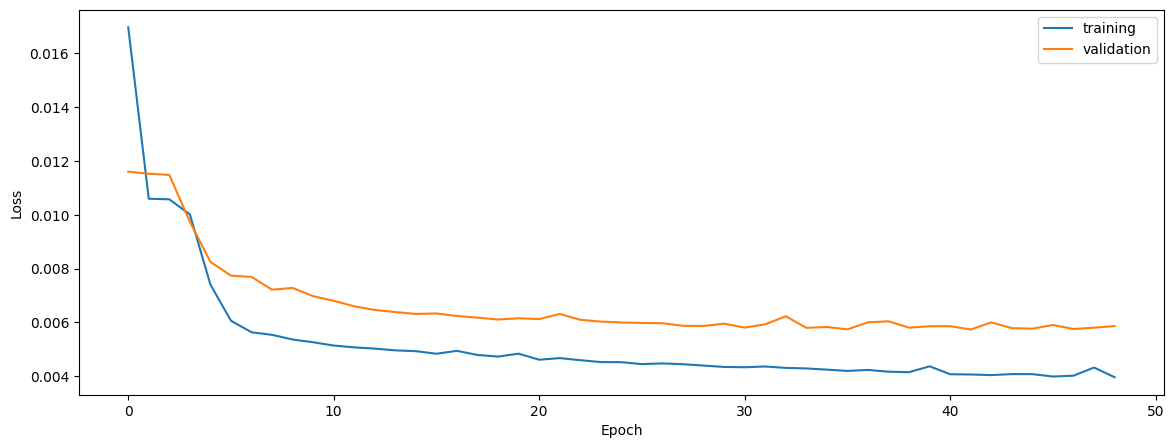

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


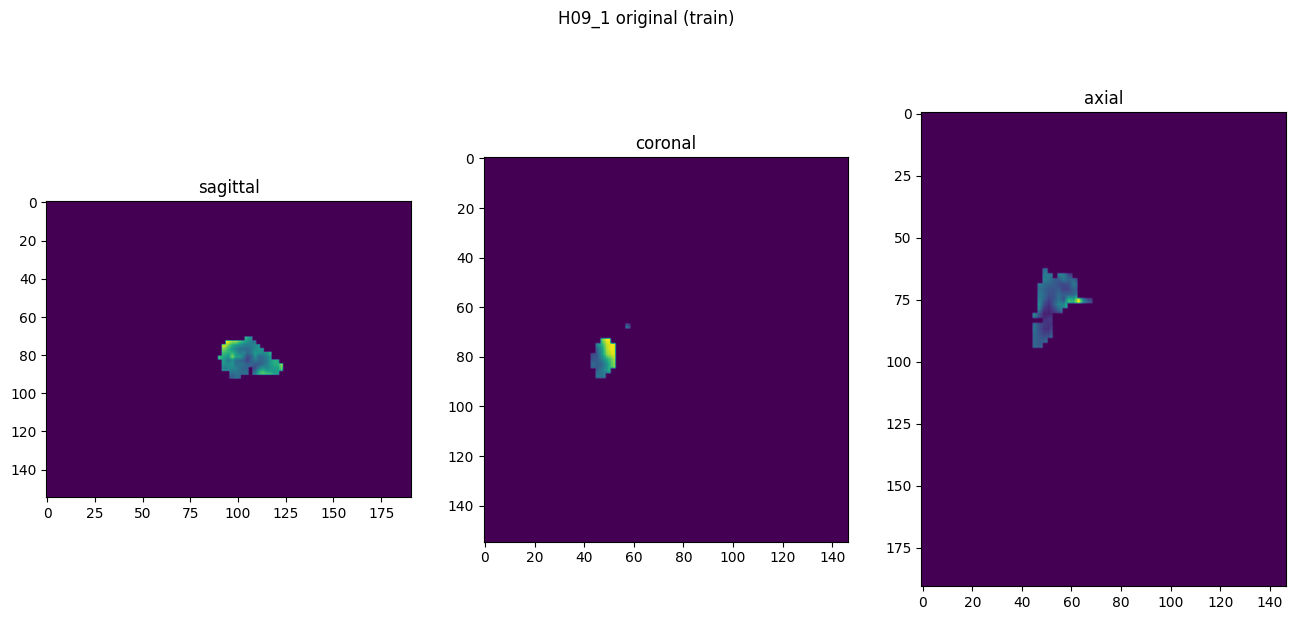

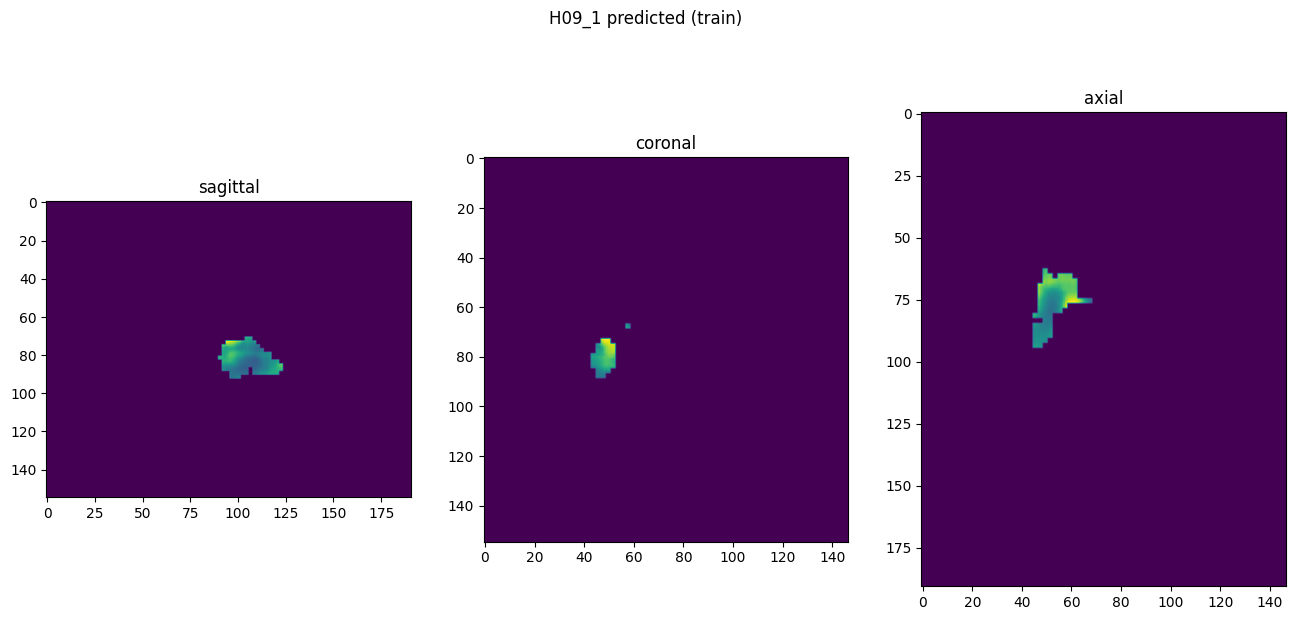

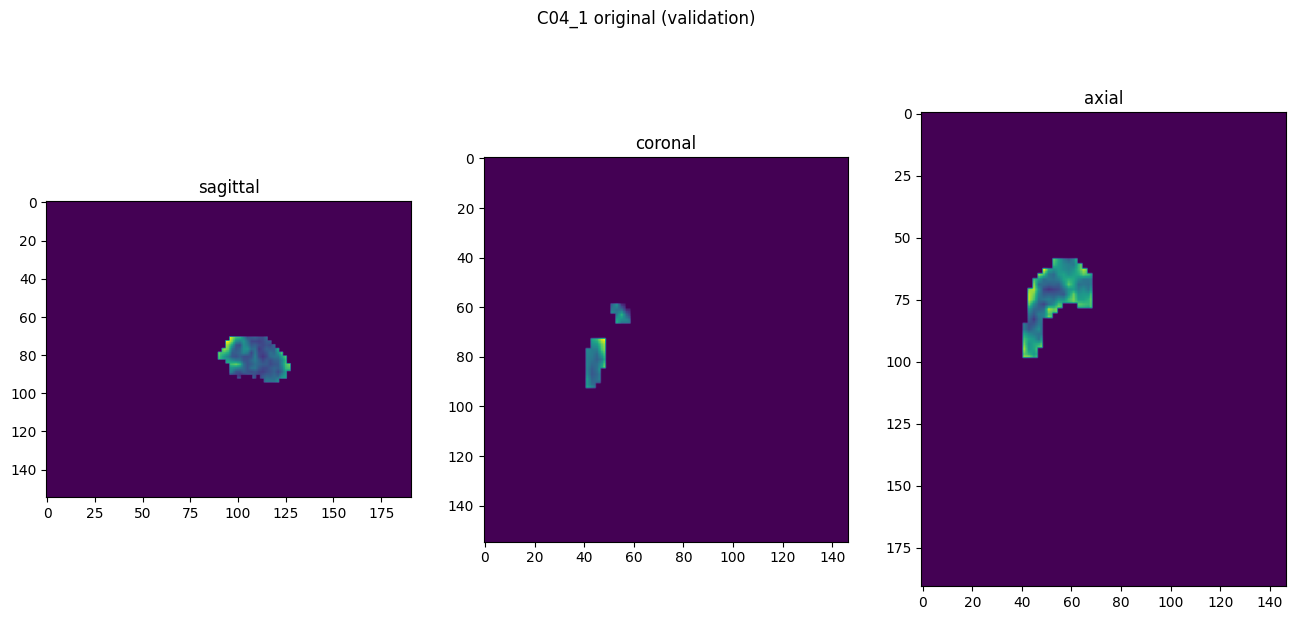

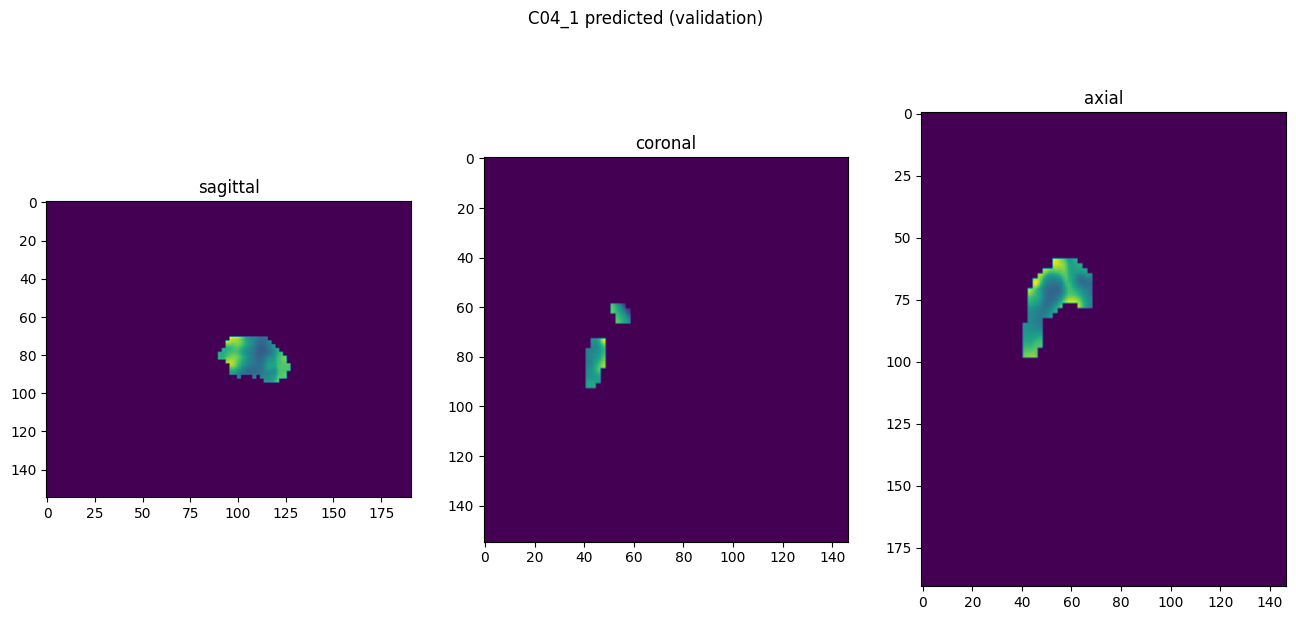

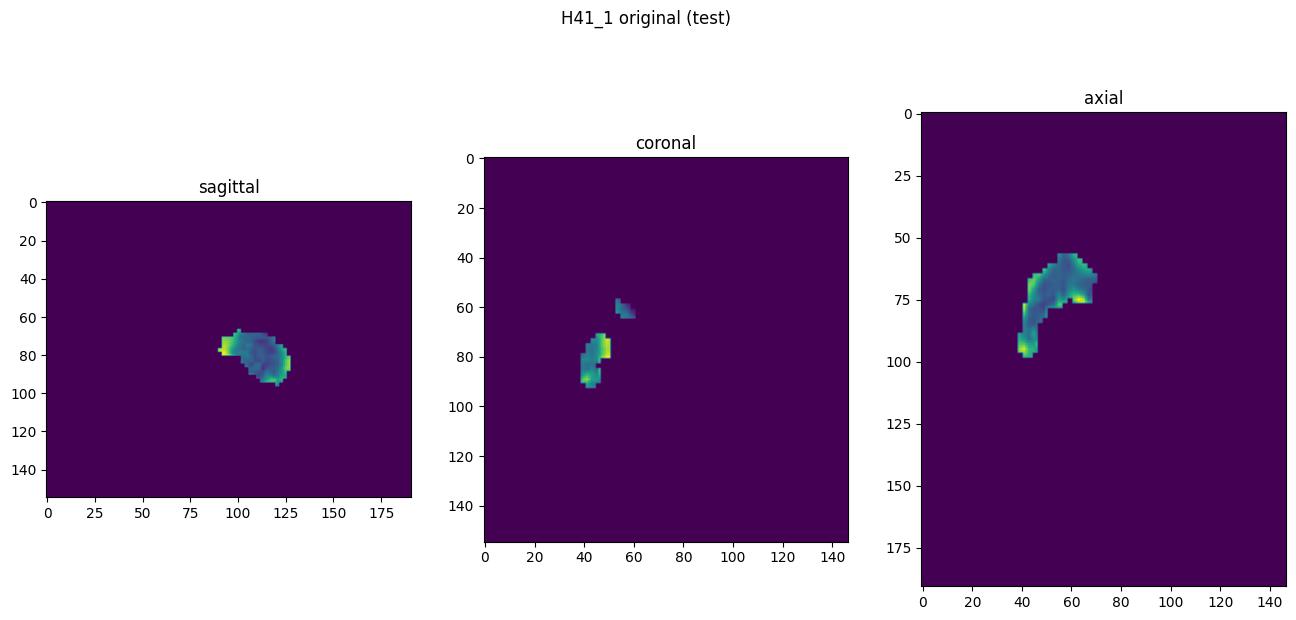

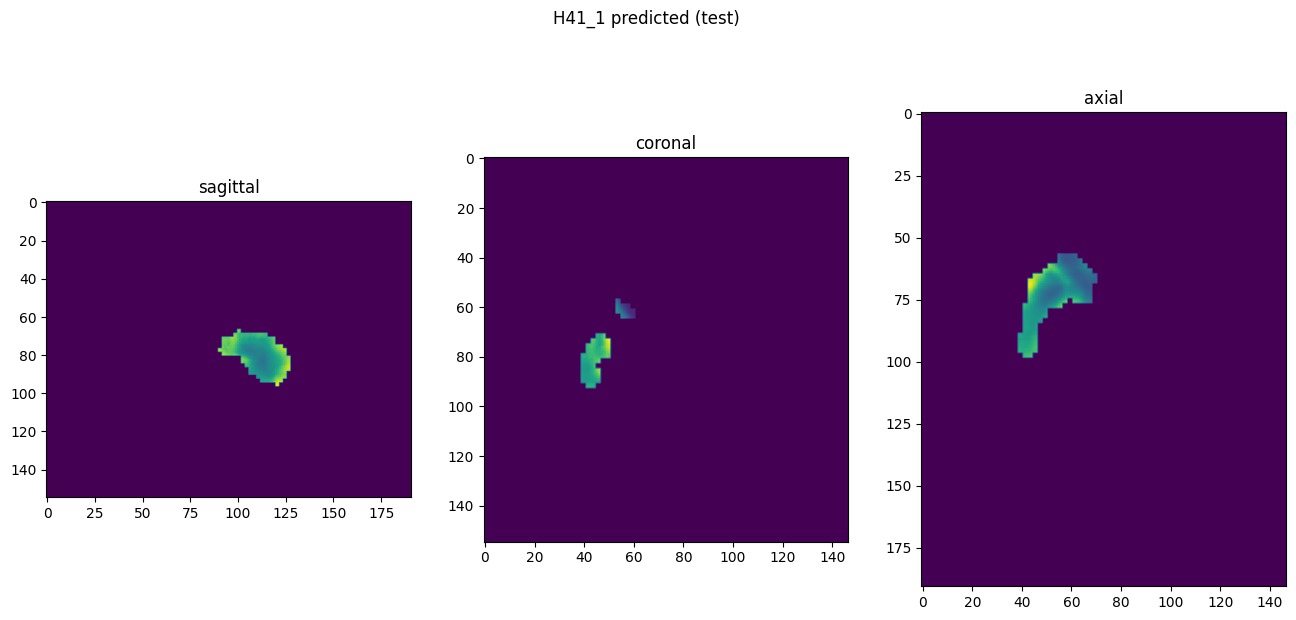

In [10]:
showResults(model, gen, threshold=None, background=False)